# Library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
import re
from typing import List, Tuple
import math
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.impute import KNNImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from sklearn.feature_selection import VarianceThreshold
from scipy.stats import chi2_contingency
import string
import spacy
import joblib
nlp = spacy.load('en_core_web_sm')

# Functions

I define a set of functions that I will use in the analyses so as to automate the analyses and avoid duplication of code

## NaN Value Functions & Outliers

In [7]:
def find_missing_values(df: pd.DataFrame, threshold: float = 0.0, subset: List[str] = None) -> dict:
    """
    Found columns with missing values above a certain threshold.

    Args:
    - df: DataFrame to analyze.
    - threshold: Threshold above which columns are considered to have missing values.
    - subset: List of columns to analyze (default is None).

    Returns:
    - Dictionary with columns and their missing percentage.
    """
    # If subset is None, use all columns 
    if subset is None:
        subset = df.columns

    # Calculation of the percentage of null values for each column in the subset
    missing_percentage = df[subset].isnull().mean()

    # Filter columns with missing values above the threshold
    columns_above_threshold = missing_percentage[missing_percentage >= threshold]
    
    # Return a dictionary with the columns and their missing percentage
    return columns_above_threshold.to_dict()


def fill_missing_values(df: pd.DataFrame, column: str, method: str = 'mean', n_neighbors: int = 5) -> pd.DataFrame:
    """
    Fill missing values in a column using different methods.

    Args:
    - df: DataFrame to analyze.
    - column: Column to fill.
    - method: Method to use for filling missing values (default is 'mean').
    - n_neighbors: Number of neighbors to use for KNN imputation (default is 5).

    Returns:
    - DataFrame with missing values filled in the specified column.
    """
    if method == 'mean':
        # Fill with the mean
        df[column] = df[column].fillna(df[column].mean())
    
    elif method == 'median':
        # Fill with the median
        df[column] = df[column].fillna(df[column].median())
    
    elif method == 'mode':
        # Fill with the mode
        df[column] = df[column].fillna(df[column].mode()[0])
    
    elif method == 'interpolation':
        # Fill using linear interpolation
        df[column] = df[column].interpolate(method='linear')
    
    elif method == 'knn':
        # Fill using KNN imputation
        imputer = KNNImputer(n_neighbors=n_neighbors)
        df[column] = imputer.fit_transform(df[[column]])
    
    else:
        raise ValueError("Invalid method. Choose from 'mean', 'median', 'mode', 'interpolation', 'knn'.")
    
    return df

def detect_and_categorize_outliers(df: pd.DataFrame, column: str, multiplier: float = 1.5) -> pd.DataFrame:
    """
    Detect and categorize outliers in a column using the IQR method.

    Args:
    - df: DataFrame to analyze.
    - column: Column to analyze.
    - multiplier: Multiplier to use for the IQR method (default is 1.5).

    Returns:
    - DataFrame with a new column 'outlier_category' that categorizes outliers.
    """
    # Calculate the first and third quartiles
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    # Calculate the lower and upper bounds
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    
    # Create the 'outlier_category' column to classify the outliers
    lower_small = lower_bound - IQR
    lower_medium = lower_bound - 2 * IQR
    upper_small = upper_bound + IQR
    upper_medium = upper_bound + 2 * IQR
    
    # Define the conditions for each category of outliers
    conditions = [
        (df[column] < lower_bound) & (df[column] >= lower_small),  # Small outlier below the limit
        (df[column] < lower_small) & (df[column] >= lower_medium),  # Medium outlier below the limit
        (df[column] < lower_medium),  # Extreme outlier below the limit
        (df[column] > upper_bound) & (df[column] <= upper_small),  # Small outlier above the limit
        (df[column] > upper_small) & (df[column] <= upper_medium),  # Medium outlier above the limit
        (df[column] > upper_medium)  # Extreme outlier above the limit
    ]
    
    # Define the labels for each category of outliers
    labels = [
        'small outlier below', 'medium outlier below', 'extreme outlier below',
        'small outlier above', 'medium outlier above', 'extreme outlier above'
    ]
    
    # Assign the category to each row based on the conditions
    df['outlier_category'] = pd.Series(np.select(conditions, labels, default='non outlier'))
    
    # Return the DataFrame with the new column
    outliers = df[df['outlier_category'] != 'non outlier']
    
    return outliers

## Data Cleaning Functions

In [8]:
def boolean_to_integer(df: pd.DataFrame, columns: List[str]) -> pd.DataFrame:
    """
    Convert boolean columns to integers.

    Args:
    - df: DataFrame to modify.
    - columns: List of columns to convert.

    Returns:
    - DataFrame with the converted columns.
    """
    df.loc[:, columns] = df[columns].astype(int)
    return df

def string_to_integer(df: pd.DataFrame, columns: List[str], value1: str = 'Yes', value2: str = 'No') -> pd.DataFrame:
    """
    Convert string columns to integers.

    Args:
    - df: DataFrame to modify.
    - columns: List of columns to convert.
    - value1: Value to convert to 1 (default is 'Yes').
    - value2: Value to convert to 0 (default is 'No').

    Returns:
    - DataFrame with the converted columns.
    """
    df.loc[:, columns] = df[columns].replace({value1: 1, value2: 0})
    return df

def preprocess_text(text: str, length_threshold: int = 3, remove_numbers: bool = False, remove_verbs: bool = True) -> str:
    """
    Preprocess text data by removing punctuation, numbers, stopwords, and lemmatizing the tokens.

    Args:
    - text: Text to preprocess.
    - length_threshold: Minimum length of words to keep (default is 3).
    - remove_numbers: Whether to remove numbers and alphanumeric characters (default is False).
    - remove_verbs: Whether to remove verbs (default is True).

    Returns:
    - Preprocessed text.
    """
    # Transform the text to lowercase
    text = text.lower()

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove numbers and alphanumeric characters
    if remove_numbers:
        # Remove numbers and alphanumeric characters
        text = re.sub(r'\b\w*\d\w*\b', '', text)

    # Tokenize the text
    doc = nlp(text)
    
    # Lemmatize the tokens and remove stopwords
    tokens = [token.lemma_ for token in doc if 
              (not remove_verbs or token.pos_ != 'VERB') and 
              token.text not in stopwords.words('english')]

    # Remove short words
    tokens = [word for word in tokens if len(word) > length_threshold]
    
    return " ".join(tokens)

## Construct Data Functions

In [176]:
def categorical_encoding(df: pd.DataFrame, columns: List[str]) -> pd.DataFrame:
    """
    Encode categorical columns as integers.

    Args:
    - df: DataFrame to modify.
    - columns: List of columns to encode.

    Returns:
    - DataFrame with the encoded columns.
    """
    for col in columns:
        df[col] = pd.Categorical(df[col])
    return df

def one_hot_encoding(df: pd.DataFrame, columns: List[str]) -> pd.DataFrame:
    """
    Encode categorical columns using one-hot encoding.

    Args:
    - df: DataFrame to modify.
    - columns: List of columns to encode.

    Returns:
    - DataFrame with the one-hot encoded columns.
    """
    df = pd.get_dummies(df, columns=columns)
    return df

def scale(df: pd.DataFrame, scaler: str, columns: List[str], scaler_filename: str = None, scaler_filename_prop: str = None) -> pd.DataFrame:
    """
    Scale the specified columns using a scaler.

    Args:
    - df: DataFrame to modify.
    - scaler: Scaler to use ('standard' or 'minmax').
    - columns: List of columns to scale.
    - scaler_filename: Name of the file to save the scaler for the 'Number of bidders' and 'Classification of the multifactor criteria (%)' columns.
    - scaler_filename_prop: Name of the file to save the scaler for the 'Proportion between the effective and initial price (%)' column.

    Returns:
    - DataFrame with the scaled columns.
    """
    if scaler not in ['standard', 'minmax']:
        raise ValueError("Invalid scaler. Choose from 'standard', 'minmax'.")
    
    if scaler == 'standard':
        scaler = StandardScaler()
    else:
        scaler = MinMaxScaler()

    if scaler_filename:
        scaler_to_save = MinMaxScaler()
        scaler_to_save.fit(df[['Classification of the multifactor criteria (%)', 'Number of bidders']])
        joblib.dump(scaler_to_save, scaler_filename)
    
    if scaler_filename_prop:
        scaler_to_save = MinMaxScaler()
        scaler_to_save.fit(df[['Proportion between the effective and initial price (%)']])
        joblib.dump(scaler_to_save, scaler_filename_prop)

    df[columns] = scaler.fit_transform(df[columns])

    return df

def discretize(df: pd.DataFrame, column: str, n_bins: int, strategy: str = 'quantile', print_bins: bool = False, keep_old: bool = False) -> pd.DataFrame:
    """
    Discretize a column into bins.

    Args:
    - df: DataFrame to modify.
    - column: Column to discretize.
    - n_bins: Number of bins to create.
    - strategy: Strategy to use for discretization ('quantile' or 'uniform').
    - print_bins: Whether to print the bin edges (default is False).
    - keep_old: Whether to keep the original column (default is False).

    Returns:
    - DataFrame with the discretized column.
    """
    if strategy not in ['quantile', 'uniform']:
        raise ValueError("Metodo non valido. Scegli tra: 'quantile', 'uniform'.")

    # Mask for NaN values
    mask_nan = df[column].isna()

    # Discretize the column
    discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy=strategy)
    discretized_values = discretizer.fit_transform(df.loc[~mask_nan, [column]])

    # Replace the original column with the discretized values
    if keep_old:
        df[column + '_old'] = df[column]

    df.loc[~mask_nan, column] = discretized_values

    # Print the bin edges
    if print_bins:
        return df, discretizer.bin_edges_[0]

    return df

## KNNInputer Functions

In [177]:
def plot_significant_correlations_heatmap(df: pd.DataFrame, target_column: str, threshold: float = 0.3) -> List[str]:
    """
    Plot a heatmap of significant correlations with the target column.

    Args:
    - df: DataFrame with the data.
    - target_column: Name of the target column.
    - threshold: Threshold for significant correlations (default is 0.3).

    Returns:
    - List of columns with significant correlations.
    """
    # Evaluate the correlation matrix
    correlation_matrix = df.corr(numeric_only=True)
    
    # Filter only the correlations with the target column
    correlation_with_submission = correlation_matrix[target_column]

    # Filter only the significant correlations
    significant_correlations = correlation_with_submission[
        (correlation_with_submission >= threshold) | (correlation_with_submission <= -threshold)
    ]

    # Plot the heatmap of significant correlations
    heatmap_data = correlation_matrix.loc[significant_correlations.index, significant_correlations.index]
    plt.figure(figsize=(8, 8))
    sns.heatmap(heatmap_data, annot=True, cmap='magma', center=0, square=True)
    plt.title(f'Heatmap of Significant Correlations with {target_column}')
    plt.show()

    return significant_correlations.index.tolist()

def evaluate_knn_imputation(df: pd.DataFrame, target_column: str, cols_of_interest: List[str], neighbors_list: List[int]):
    """
    Evaluate the mean imputation for different numbers of neighbors.

    Args:
    - df: DataFrame with the data.
    - target_column: Name of the target column.
    - cols_of_interest: List of columns to use for imputation.
    - neighbors_list: List of numbers of neighbors to evaluate.

    Returns:
    - Plot of the mean imputation for different numbers of neighbors.
    """
    data_to_impute = df[cols_of_interest + [target_column]]
    imputed_means = []

    for n in neighbors_list:
        imputer = KNNImputer(n_neighbors=n, weights='uniform')
        imputed_data = imputer.fit_transform(data_to_impute)

        # Extract the mean of the target column
        imputed_mean = np.mean(imputed_data[:, -1])  # Last column is the target column
        imputed_means.append(imputed_mean)

    # Plot the mean imputation for different numbers of neighbors
    plt.figure(figsize=(10, 6))
    plt.plot(neighbors_list, imputed_means, marker='o')
    plt.title('Mean Imputation for Different n_neighbors')
    plt.xlabel('Number of Neighbors (n_neighbors)')
    plt.ylabel('Mean of Imputed Submission Deadline (days)')
    plt.xticks(neighbors_list)
    plt.grid()
    plt.show()

def knn_impute_data(df: pd.DataFrame, cols_of_interest: List[str], target_column: str, n_neighbors: int = 5, weights: str = 'uniform') -> pd.DataFrame:
    """
    Impute missing values using the KNN imputer.

    Args:
    - df: DataFrame with the data.
    - cols_of_interest: List of columns to use for imputation.
    - target_column: Name of the target column.
    - n_neighbors: Number of neighbors to use for imputation (default is 5).
    - weights: Weights to use for imputation (default is 'uniform').

    Returns:
    - DataFrame with the imputed data
    """
    # Select the columns of interest
    data_to_impute = df[cols_of_interest + [target_column]]

    # Create the KNN imputer
    imputer = KNNImputer(n_neighbors=n_neighbors, weights=weights)

    # Impute the missing values
    imputed_data = imputer.fit_transform(data_to_impute)
    
    # Create a DataFrame with the imputed data
    df_imputed = pd.DataFrame(imputed_data, columns=data_to_impute.columns)

    return df_imputed.loc[:, ~df_imputed.columns.duplicated()]

## Feature Selection Functions

In [9]:
def plot_high_correlation_matrix(df: pd.DataFrame, threshold: float = 0.8, figsize: Tuple[int, int] = (10, 8)):
    """
    Plot a heatmap of the correlation matrix with a threshold.

    Args:
    - df: DataFrame with the data.
    - threshold: Threshold for the correlation (default is 0.8).
    - figsize: Size of the figure (default is (10, 8)).

    Returns:
    - Plot of the correlation matrix with the threshold.
    """
    correlation_matrix = df.corr(numeric_only=True)

    # Create a mask to hide the upper triangle
    mask = abs(correlation_matrix) < threshold

    plt.figure(figsize=figsize)
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', mask=mask)
    plt.title(f'Correlation Matrix (Threshold: {threshold})')
    plt.show()

def chi_square_and_pvalue_matrices(df: pd.DataFrame, alpha: float = 0.05, figsize: Tuple[int, int] = (10, 8)):
    """
    Evaluate the chi-square test and create the matrices of chi-square values and p-values.

    Args:
    - df: DataFrame with the data.
    - alpha: Significance level for the chi-square test (default is 0.05).
    - figsize: Size of the figure (default is (10, 8)).

    Returns:
    - Matrices of chi-square values and p-values.
    """
    categorical_cols = df.select_dtypes(include=['object']).columns
    
    chi2_matrix = pd.DataFrame(index=categorical_cols, columns=categorical_cols)
    p_value_matrix = pd.DataFrame(index=categorical_cols, columns=categorical_cols)
    
    for i in range(len(categorical_cols)):
        for j in range(i + 1, len(categorical_cols)):
            var1 = categorical_cols[i]
            var2 = categorical_cols[j]
            contingency_table = pd.crosstab(df[var1], df[var2])
            
            chi2, p, _, _ = chi2_contingency(contingency_table)
            
            # Check if the p-value is below the significance level
            if p < alpha:
                chi2_matrix.loc[var1, var2] = chi2
                chi2_matrix.loc[var2, var1] = chi2
                p_value_matrix.loc[var1, var2] = p
                p_value_matrix.loc[var2, var1] = p
            else:
                chi2_matrix.loc[var1, var2] = None
                chi2_matrix.loc[var2, var1] = None
                p_value_matrix.loc[var1, var2] = None
                p_value_matrix.loc[var2, var1] = None

    chi2_matrix = chi2_matrix.astype(float)
    p_value_matrix = p_value_matrix.astype(float)

    # Visualize the p-value matrix
    plt.figure(figsize=figsize)
    sns.heatmap(p_value_matrix, annot=True, cmap='coolwarm', fmt='.2g', cbar_kws={'label': 'p-value'})
    plt.title(f'P-value Matrix of Categorical Variables (Chi-Square Test) - alpha={alpha}')
    plt.show()
    
    # Visualize the chi-square matrix
    plt.figure(figsize=figsize)
    sns.heatmap(chi2_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar_kws={'label': 'Chi-Square'})
    plt.title('Chi-Square Matrix of Categorical Variables (Filtered by p-value)')
    plt.show()

    return chi2_matrix, p_value_matrix

def select_features_variance(df: pd.DataFrame, threshold: float = 0.01) -> pd.DataFrame:
    """
    Select features based on variance threshold.

    Args:
    - df: DataFrame with the data.
    - threshold: Threshold for the variance (default is 0.01).

    Returns:
    - DataFrame with the selected features.
    """
    # Select only the numeric columns
    df_numeric = df.select_dtypes(include=[float, int])

    # Apply the variance threshold
    selector = VarianceThreshold(threshold=threshold)
    df_selected = selector.fit_transform(df_numeric)

    feature_selected = df_numeric.columns[selector.get_support(indices=True)]
    return pd.DataFrame(df_selected, columns=feature_selected)

def calculate_entropy_normalized(series: pd.Series) -> float:
    """
    Calculate the normalized entropy of a categorical variable.

    Args:
    - series: Series with the categorical variable.

    Returns:
    - Normalized entropy of the categorical variable.
    """
    # Evaluate the probabilities of each class
    probabilities = series.value_counts(normalize=True)

    # Calculate the entropy
    entropy = -np.sum(probabilities * np.log2(probabilities))

    # Calculate the maximum entropy
    n_classes = len(probabilities)
    max_entropy = np.log2(n_classes)
    
    # Normalize the entropy
    normalized_entropy = entropy / max_entropy if max_entropy > 0 else 0
    return normalized_entropy

# Summary Comment on the Data Preprocessing and Analysis Process

During the data analysis process, I performed a series of fundamental operations to prepare the dataset for cluster analysis. <br> Here is a summary of the activities carried out, expanding the **Data Preparation** phase of the **CRISP-DM** methodology:

1. **`Exploratory Data Analysis (EDA)`**:
   - Graphs (such as histplot, barplot, boxplot) were generated to visualize relationships between variables and identify potential trends or correlations in the dataset.
   - I examined distributions and statistical relationships to better understand the data structure.

2. **`Data Cleaning and Initial Feature Selection`**:
   - I removed unnecessary columns, handled null values in the dataset, and removed outliers.
   - For **outlier** detection, I used the **interquartile range** (IQR) and analyzed distributions through graphs and boxplots. The outliers were classified into three categories: **extreme**, **medium**, and **small**. This classification allowed me to remove only the extreme outliers that distorted the distribution, while keeping the less influential ones.
   - I used the **KNN imputer** to handle null values, ensuring accurate imputation based on similarity with other observations. Before applying imputation, I selected the features most correlated with the target variable to be imputed, improving the method's accuracy. <br> The optimal **k** parameter was chosen based on the **stability of the mean** of the feature selected for imputation.

3. **`Construct Data`**:
   - I created new columns derived from text (`Cpvs Designation`) and transformed date columns to extract meaningful information, such as `Signing Year`, `Signing Month`, `Closing Date Year`, `Closing Date Month`.
   - I also transformed the column `Justification for deadline change`, which summarizes various justifications for deadline changes extracted from free text.
   - The numerical variables were normalized to ensure they all had a similar impact on subsequent analyses.
   - I also discretized some variables (such as `Base Bid Price`, `Effective Price`, `Initial Price`, and others), studying their distribution, to improve data interpretability and clarity.
   - I avoided using PCA to ensure that variables remained easily explainable from a semantic point of view.

4. **`Feature Selection`**:
   - Initially, I used **feature selection** to eliminate variables with a high presence of null values or extremely low variance (this step was performed before data cleaning in conjunction with **EDA**).
   - Later, after completing other data cleaning and preparation operations, I applied techniques based on **variance**, **entropy**, and **correlation analysis**. This allowed me to eliminate the last insignificant features, reducing the dataset's dimensionality and retaining only the most informative features for the clustering task.

5. **`Integrate Data`**:
   - After completing the cleaning, transformation, and feature selection operations, I obtained an optimized new DataFrame. <br> This consolidated dataset serves as the starting point for cluster analysis.

It is important to note that the transformations applied to this dataset are not final. The data analysis process is inherently iterative and may require several stages of review and modification. However, I wanted to provide an initial general cut to simplify cluster and association analysis.

This simplification helps avoid confusion from an excessive number of variables, allowing for a clearer and more straightforward interpretation of the results. The operations carried out so far provide a solid foundation for further exploration and optimization, ensuring that the clustering model can be implemented effectively and meaningfully.

# EDA - Data Cleaning e Feature Engineering - Costruct Data

In this section, I will analyze the features, perform the initial analyses on the variable distributions, remove any redundant and unnecessary features, handle null values and outliers for each column, and create new features from text and existing variables.<br>
Thus, we will cover all the phases of Data Preparation.

The dataset is related to 5,214 public construction contracts in Portugal, collected between 2015 and 2022. It is characterised by 37 different properties/features, such as initial price, actual price, award criteria and execution time.

**Mapping Feature:**

| **ID** | **Description** | **Data Type** | **Unit/Format** |
|--------|-----------------|---------------|-----------------|
| ID | Identification Number | Integer | N/A |
| Short Description | Short description of the object of the contract | Text | N/A |
| Cpvs | Common Procurement Vocabulary Code | Text | N/A |
| Cpvs Designation | Cpvs code denomination | Text | N/A |
| Environmental Criteria | Whether the environmental criterion was considered in the tender | Boolean | T/F |
| Publication year | Year of publication of tender in the DRE | Date | YYYY |
| Close year | Year of closing in the Portal Base | Date | YYYY |
| Country | Country of execution of the project | Text | N/A |
| Municipality | Municipality where the project is carried out | Text | N/A |
| District | District where the project is carried out | Text | N/A |
| District Code | District identifier code, organised alphabetically and numbered 1 to 20 | Integer | N/A |
| Submission deadline | Deadline for proposal submission | Integer | Days |
| Signing Date | Date of Contract Signing | Date | DD-MM-YYYY |
| Closing Date | Closing Date of the procedure in the Portal Base | Date | DD-MM-YYYY |
| Difference between the closing and signing dates | Difference between closing and signing dates | Integer | Days |
| Execution Deadline | Expected deadline for the execution of the work | Integer | Days |
| Base Bid Price | Base bid price for tenders | Double | € |
| Initial Price | Starting price agreed upon between the contractor and tender winner | Double | € |
| Initial Price Class | 1 - Between 0 and 250 thousand; 2 - between 250 thousand and 1 Million; 3 - over 1 Million | Integer | N/A |
| Effective Price | Effective price at the end of the work | Double | € |
| Difference between the effective and initial price | Difference between the initial price and effective price | Double | € |
| Proportion between the effective and initial price | Starting price divided by the Effective Price multiplied by 100 | Double | Percentage |
| Award Criteria | Allocation criteria used to rank bids during a public tender | Text | N/A |
| Award Criteria Class | 1 - Multifactor Criterion; 2 - Lowest Price Criterion; 0 - Missing Award Criterion | Integer | N/A |
| Classification of multifactor criteria | Weight of the "price" factor in the multifactor criterion | Double | Percentage |
| Collateral | Value of collateral, if applicable | Text | Percentage, € |
| Published in the EU journal | If the contract was published in an EU journal | Boolean | T/F |
| Contract end type | e.g. Complete fulfilment of contract or Non-fulfilment of contract | Text | N/A |
| Number of bidders | Number of bidders in the tender | Integer | N/A |
| Involves joint procurement | If there was joint procurement with several entities | Boolean | T/F |
| Awarded by a central purchasing body | If the contract was awarded by a central purchasing body | Boolean | T/F |
| Conclusion of a framework agreement | If the contract was concluded by a framework agreement | Boolean | T/F |
| Electronic auction | Whether the contract was executed by electronic auction | Boolean | T/F |
| Negotiation phase | If a negotiation phase was adopted | Boolean | T/F |
| Contracting by Lots | Whether the procurement was conducted in lots | Boolean | T/F |
| Justification for deadline change | Justification for deadline change (free format) | Text | N/A |
| Justification for price change | Justification for price change (free format) | Text | N/A |

In [179]:
df1 = pd.read_excel('PPPData_EN_1.0.xlsx')
original_shape = df1.shape
df1.head(3)

Count       ID                                 Short Description1  \
0      0  9347658  Construction of the domestic and rainwater dra...   
1      1  9331053                Repairs to Municipal Swimming Pools   
2      2  9328338  Rehabilitation contract for the beachside ramp...   

         Cpvs                                   Cpvs Designation  \
0  45231300-8   Construction work for water and sewage pipelines   
1  45212290-5  Repair and maintenance work in connection with...   
2  45262330-3                               Concrete repair work   

   Environmental criteria (T/F)  Publication Year  Close Year   Country  \
0                         False            2020.0        2022  Portugal   
1                         False            2020.0        2022  Portugal   
2                         False            2022.0        2022  Portugal   

  Municipality  ...                     Contract end type  Number of bidders  \
0       Almada  ...  Complete fulfillment of the contract                  4   
1        Viseu  ...  Complete fulfillment of the contract                  2   
2        Loulé  ...  Complete fulfillment of the contract                  5   

   Involves joint procurement (with several entities) (T/F)  \
0                                                0.0          
1                                                0.0          
2                                                NaN          

  Awarded by a central purchasing body (T/F)  \
0                                        0.0   
1                                        NaN   
2                                        NaN   

  Conclusion of a framework agreement (T/F)  Electronic auction (T/F)  \
0                                       0.0                       0.0   
1                                       NaN                       NaN   
2                                       NaN                       NaN   

   Negotiation phase (T/F)  Contracting by lots (T/F)  \
0                      0.0                        NaN   
1                      NaN                        0.0   
2                      NaN                        NaN   

                   Justification for deadline change  \
0  the project was finished ahead of schedule, ev...   
1                                                NaN   
2  completion of work carried out before the dead...   

   Justification for price change  
0                    price review  
1                             NaN  
2                             NaN  

[3 rows x 38 columns]

In [180]:
df1.shape

(5214, 38)

In [181]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5214 entries, 0 to 5213
Data columns (total 38 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Count                                                     5214 non-null   int64  
 1   ID                                                        5214 non-null   int64  
 2   Short Description1                                        5214 non-null   object 
 3   Cpvs                                                      5214 non-null   object 
 4   Cpvs Designation                                          5214 non-null   object 
 5   Environmental criteria (T/F)                              5214 non-null   bool   
 6   Publication Year                                          5166 non-null   float64
 7   Close Year                                                5214 non-null   int64  
 8   Country           

In [182]:
df1.describe(exclude=['object'])

Count            ID Environmental criteria (T/F)  \
count   5214.000000  5.214000e+03                         5214   
unique          NaN           NaN                            2   
top             NaN           NaN                        False   
freq            NaN           NaN                         4915   
mean    2606.500000  4.279524e+06                          NaN   
std     1505.296482  2.319179e+06                          NaN   
min        0.000000  7.919400e+04                          NaN   
25%     1303.250000  2.147325e+06                          NaN   
50%     2606.500000  4.569879e+06                          NaN   
75%     3909.750000  6.169590e+06                          NaN   
max     5213.000000  9.347658e+06                          NaN   

        Publication Year   Close Year  District Code  \
count        5166.000000  5214.000000    5062.000000   
unique               NaN          NaN            NaN   
top                  NaN          NaN            NaN   
freq                 NaN          NaN            NaN   
mean         2016.923926  2018.932298      10.382458   
std             2.711387     2.306510       5.695764   
min          2009.000000  2013.000000       1.000000   
25%          2015.000000  2017.000000       6.000000   
50%          2017.000000  2019.000000      11.000000   
75%          2019.000000  2021.000000      14.000000   
max          2022.000000  2022.000000      20.000000   

        Submission deadline (days)  Diference between close and signing dates  \
count                  4912.000000                                5214.000000   
unique                         NaN                                        NaN   
top                            NaN                                        NaN   
freq                           NaN                                        NaN   
mean                     23.866450                                 588.179517   
std                      11.266549                                 419.145807   
min                       1.000000                                   6.000000   
25%                      15.000000                                 289.250000   
50%                      21.000000                                 496.000000   
75%                      30.000000                                 767.750000   
max                     156.000000                                3934.000000   

        Execution deadline (days)  Base Bid Price (€)  ...  \
count                 5214.000000        5.166000e+03  ...   
unique                        NaN                 NaN  ...   
top                           NaN                 NaN  ...   
freq                          NaN                 NaN  ...   
mean                   206.292482        8.444718e+05  ...   
std                    156.556319        2.686460e+06  ...   
min                      9.000000        7.750000e+03  ...   
25%                     90.000000        2.019000e+05  ...   
50%                    154.000000        3.358588e+05  ...   
75%                    270.000000        6.803288e+05  ...   
max                   1095.000000        1.100000e+08  ...   

        Proportion between the effective and initial price (%)  \
count                                         5214.000000        
unique                                                NaN        
top                                                   NaN        
freq                                                  NaN        
mean                                           113.025378        
std                                            554.805474        
min                                              9.331023        
25%                                             98.294329        
50%                                            100.000000        
75%                                            101.528575        
max                                          39450.350379        

        Award criteria class  Classif

In [183]:
df1.describe(include=['object'])

Short Description1        Cpvs  \
count                                                5214        5214   
unique                                               5076         486   
top     Replacement of asbestos-containing fiber cemen...  45453100-8   
freq                                                    7         244   

          Cpvs Designation   Country Municipality District Signing date  \
count                 5214      5214         5042     5046         5214   
unique                 486         1          281       24         2022   
top     Refurbishment work  Portugal       Lisboa   Lisboa   21-01-2015   
freq                   244      5214          254      713           13   

       Closing date                          Award criteria  Collateral  \
count          5214                                    5214        2343   
unique         1746                                    1077          17   
top      18-11-2021  Wrong ad link \ failed to download pdf           5   
freq             15                                     965         961   

       Published in the EU journal                     Contract end type  \
count                         3734                                  5213   
unique                           2                                     6   
top                          False  Complete fulfillment of the contract   
freq                          3603                                  5178   

       Justification for deadline change Justification for price change  
count                               4481                           3569  
unique                              3045                           2042  
top                            no change                      underwork  
freq                                 180                            336

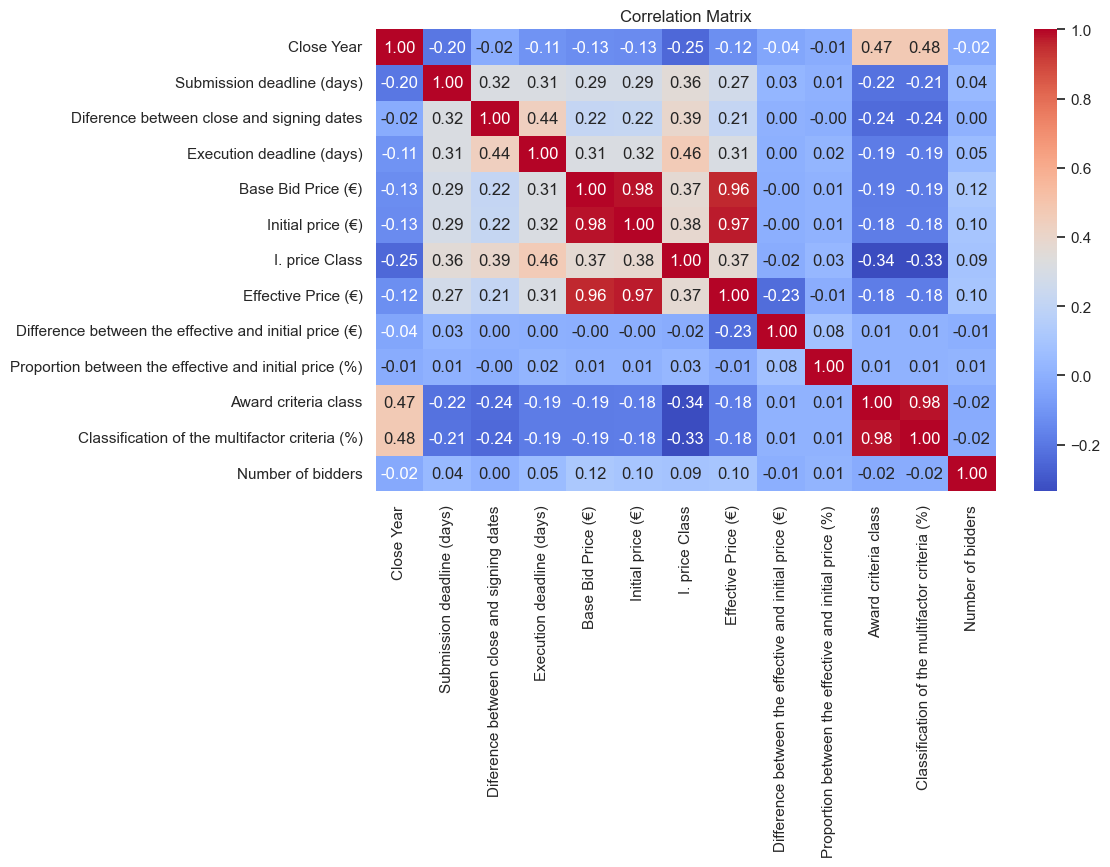

In [184]:
correlation_matrix = df1.drop(columns=['Count', 'ID', 'Environmental criteria (T/F)', 'Publication Year',
                            'District Code', 'Contracting by lots (T/F)', 'Negotiation phase (T/F)',
                            'Electronic auction (T/F)', 'Conclusion of a framework agreement (T/F)', 'Awarded by a central purchasing body (T/F)',
                            'Involves joint procurement (with several entities) (T/F)']).corr(numeric_only=True)
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

This is an initial correlation analysis that I need to be able to orientate the feature analysis that I will do in the next sections.

In [185]:
df1.isnull().sum()

Count                                                          0
ID                                                             0
Short Description1                                             0
Cpvs                                                           0
Cpvs Designation                                               0
Environmental criteria (T/F)                                   0
Publication Year                                              48
Close Year                                                     0
Country                                                        0
Municipality                                                 172
District                                                     168
District Code                                                152
Submission deadline (days)                                   302
Signing date                                                   0
Closing date                                                   0
Diference between close a

In [186]:
df1.nunique()

Count                                                       5214
ID                                                          5214
Short Description1                                          5076
Cpvs                                                         486
Cpvs Designation                                             486
Environmental criteria (T/F)                                   2
Publication Year                                              14
Close Year                                                    10
Country                                                        1
Municipality                                                 281
District                                                      24
District Code                                                 20
Submission deadline (days)                                    76
Signing date                                                2022
Closing date                                                1746
Diference between close a

**Overview of the Dataset Columns**

- Several columns contain null values, with some reaching up to 60% (e.g., **Difference between the effective and initial price**).
- Other columns, such as **ID**, contain all unique values.
- Some features have redundant values compared to others.
- Some columns require pre-processing and cleaning.
- Some features contain text that requires specific treatment.

Therefore, a column-by-column analysis will follow to identify the useful features for our analyses.

## Analysis Values Each Column

In this section I analyse the various univariate distributions, considering one column at a time.

### Bool

#### Environmental criteria

In [187]:
df1['Environmental criteria (T/F)'].value_counts()

Environmental criteria (T/F)
False    4915
True      299
Name: count, dtype: int64

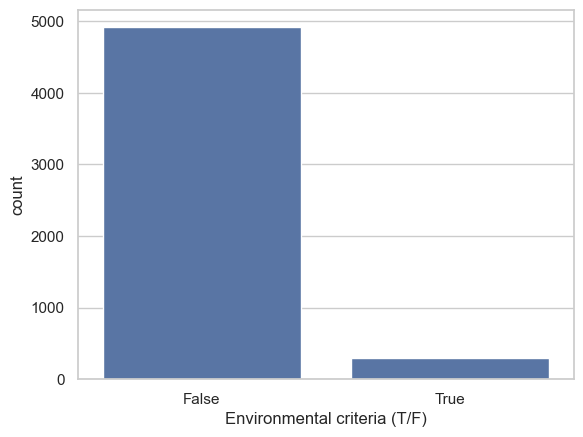

In [188]:
sns.countplot(x='Environmental criteria (T/F)', data=df1);

The feature has about 6% of values set to `True`. This could be indicative of a discriminator for particular types of procurement contracts. At the moment, without further information, I would consider this feature for analysis, re-evaluating it along with the others. If no significant discriminating features emerge, its removal could be considered at a later stage.

In [189]:
df1['Environmental criteria (T/F)'] = df1['Environmental criteria (T/F)'].astype(int)

#### Published in the EU journal

In [190]:
df1['Published in the EU journal'] = df1['Published in the EU journal'].replace({False: 0, 'TRUE ': 1, np.nan: np.nan})
df1['Published in the EU journal'].value_counts(dropna=False)

C:\Users\dommy\AppData\Local\Temp\ipykernel_13992\2640475106.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df1['Published in the EU journal'] = df1['Published in the EU journal'].replace({False: 0, 'TRUE ': 1, np.nan: np.nan})


Published in the EU journal
0.0    3603
NaN    1480
1.0     131
Name: count, dtype: int64

In [191]:
1480/df1.shape[0]

0.2838511699271193

 There are approximately 28% null values for this feature. Possible paths could be:
1. **Imputation with KNN**: Use KNN to estimate null values based on the most similar neighbours.
2. **Imputation with fashion**: Fill in the null values with the most frequent value. However, I would avoid using this strategy, as the distinction between classes would be lost: null values would be set to `False`, and we have few `True` values, which can make a difference.
3. **Feature deletion**: Remove the feature completely if it does not bring value.
My preference would be towards imputation with KNN. Before proceeding, however, I want to analyse the other features, clean them up and see if there are any significant correlations. If so, I will proceed with the use of KNN. Finally, if imputation with KNN does not yield satisfactory results, I would consider removing the feature.

#### Involves joint procurement (with several entities) (T/F)

In [192]:
df1['Involves joint procurement (with several entities) (T/F)'].value_counts(dropna=False)

Involves joint procurement (with several entities) (T/F)
NaN    3143
0.0    2067
1.0       4
Name: count, dtype: int64

In [193]:
3143/df1.shape[0]

0.6028001534330648

In this case, the percentage of NaN values is about 60%. Considering also the distribution of the other variables, I decided to eliminate the column. Filling in the missing values could introduce bias and would not guarantee a sufficiently discriminating contribution to the model.

In [194]:
df1.drop(columns=['Involves joint procurement (with several entities) (T/F)'], inplace=True)

#### Awarded by a central purchasing body (T/F)

In [195]:
df1['Awarded by a central purchasing body (T/F)'].value_counts(dropna=False)

Awarded by a central purchasing body (T/F)
NaN    3158
0.0    2055
1.0       1
Name: count, dtype: int64

Same here as for the previous feature.

In [196]:
df1.drop(columns=['Awarded by a central purchasing body (T/F)'], inplace=True)

#### Conclusion of a framework agreement (T/F)

In [197]:
df1['Conclusion of a framework agreement (T/F)'].value_counts(dropna=False)

Conclusion of a framework agreement (T/F)
0.0    3732
NaN    1481
1.0       1
Name: count, dtype: int64

In [198]:
1481/df1.shape[0]

0.28404296125815115

Although the percentage of NaN values is 28%, the column distribution is strongly unbalanced, with a clear predominance of `0.0` and only a single value of `1.0`. This imbalance would make it difficult to correctly identify records with a `True` value, thus introducing a potential bias. Therefore, I decide to delete the column.

In [199]:
df1.drop(columns=['Conclusion of a framework agreement (T/F)'], inplace=True)

#### Electronic auction (T/F)

In [200]:
df1['Electronic auction (T/F)'].value_counts(dropna=False)

Electronic auction (T/F)
0.0    3733
NaN    1481
Name: count, dtype: int64

Here, it makes no sense to fill in NaN values since the only value is 0.0. So it would be dropping as a column.

In [201]:
df1.drop(columns=['Electronic auction (T/F)'], inplace=True)

#### Negotiation phase (T/F)

In [202]:
df1['Negotiation phase (T/F)'].value_counts(dropna=False)

Negotiation phase (T/F)
0.0    3724
NaN    1481
1.0       9
Name: count, dtype: int64

In [203]:
1481/df1.shape[0]

0.28404296125815115

Here too, there are too few occurrences of True values to be able to do a fill in with KNN and be able to discriminate values, so this column is also to be eliminated.

In [204]:
df1.drop(columns=['Negotiation phase (T/F)'], inplace=True)

#### Contracting by lots (T/F)

In [205]:
df1['Contracting by lots (T/F)'].value_counts(dropna=False)

Contracting by lots (T/F)
NaN    3265
0.0    1765
1.0     184
Name: count, dtype: int64

In [206]:
3265/df1.shape[0]

0.6261986958189489

Here, the % of null values is too high 63% and therefore filling in NaN would only introduce an additional bias.

In [207]:
df1.drop(columns=['Contracting by lots (T/F)'], inplace=True)

### Date

#### Publication Year

In [208]:
df1['Publication Year'] = df1['Publication Year'].astype('Int64')
df1['Publication Year'].value_counts(dropna=False).sort_index()

Publication Year
2009      5
2010     71
2011    145
2012    144
2013    309
2014    408
2015    385
2016    563
2017    658
2018    679
2019    814
2020    724
2021    257
2022      4
<NA>     48
Name: count, dtype: Int64

At first glance, the NaN values could be deleted as they represent about 1% of the total. However, before proceeding with deletion, it is important to also consider the other fields to assess whether records with null values could have a significant impact on the overall analysis.

In [209]:
df1[df1['Publication Year'].isna()].isna().sum()

Count                                                      0
ID                                                         0
Short Description1                                         0
Cpvs                                                       0
Cpvs Designation                                           0
Environmental criteria (T/F)                               0
Publication Year                                          48
Close Year                                                 0
Country                                                    0
Municipality                                               6
District                                                   6
District Code                                              6
Submission deadline (days)                                48
Signing date                                               0
Closing date                                               0
Diference between close and signing dates                  0
Execution deadline (days

There are other NaN values especially on very relevant features like `Base Bid Price`, so I would delete these lines.

In [210]:
df1.dropna(subset=['Publication Year'], inplace=True)

I proceed with analysing the feature cleaned of null values with graphs

In [211]:
pubblication_year = df1['Publication Year'].value_counts(dropna=False).sort_index()

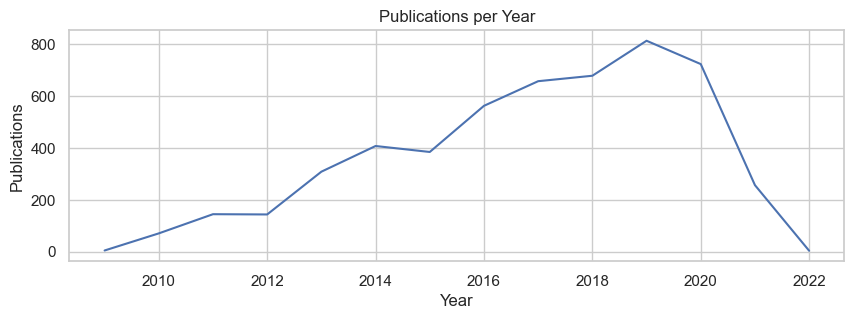

In [212]:
pubblication_year = df1['Publication Year'].value_counts(dropna=False).sort_index()
plt.figure(figsize=(10, 3))
sns.lineplot(x=pubblication_year.index, y=pubblication_year.values)
plt.title('Publications per Year')
plt.xlabel('Year')
plt.ylabel('Publications');

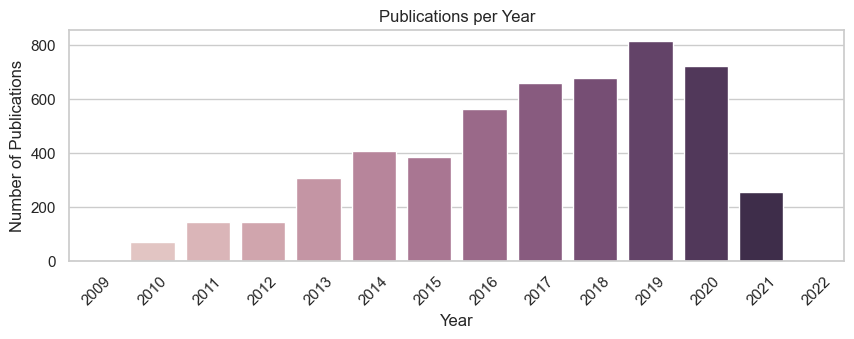

In [213]:
plt.figure(figsize=(10, 3))
sns.barplot(x=pubblication_year.index, y=pubblication_year.values, hue=pubblication_year.index, dodge=False, legend=False)
plt.title('Publications per Year')
plt.xlabel('Year')
plt.ylabel('Number of Publications')
plt.xticks(rotation=45)
plt.show()

As can be seen, the number of publications peaked in 2019, showing an upward trend from 2009 to 2019, followed by a subsequent decrease.

In [214]:
df1['Publication Year'] = df1['Publication Year'].astype('object')

#### Close Year

In [215]:
df1['Close Year'].value_counts(dropna=False).sort_index()

Close Year
2013      1
2014      2
2015    699
2016    415
2017    324
2018    495
2019    719
2020    858
2021    986
2022    667
Name: count, dtype: int64

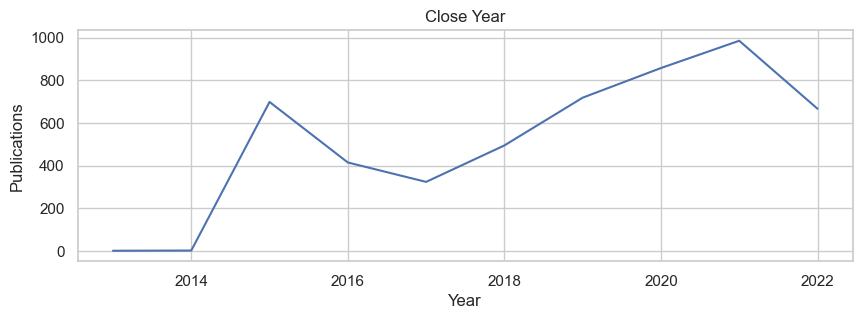

In [216]:
close_year = df1['Close Year'].value_counts(dropna=False).sort_index()
plt.figure(figsize=(10, 3))
sns.lineplot(x=close_year.index, y=close_year.values)
plt.title('Close Year')
plt.xlabel('Year')
plt.ylabel('Publications');

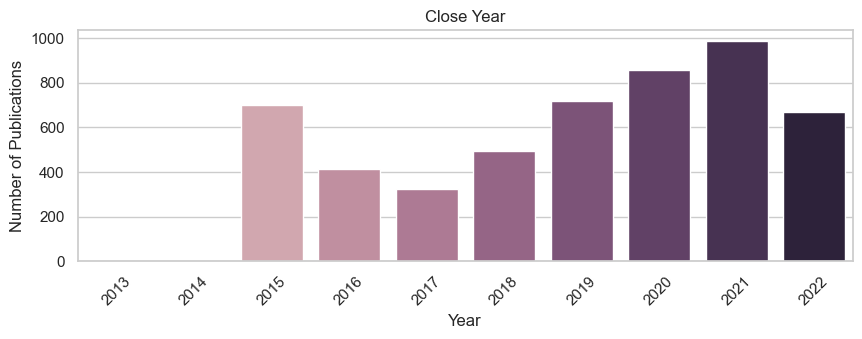

In [217]:
plt.figure(figsize=(10, 3))
sns.barplot(x=close_year.index, y=close_year.values, hue=close_year.index, dodge=False, legend=False)
plt.title('Close Year')
plt.xlabel('Year')
plt.ylabel('Number of Publications')
plt.xticks(rotation=45)
plt.show()

Here there are no null values and here too there is an upward trend between 2017 and 2021.

In [218]:
df1['Close Year'] = df1['Close Year'].astype('object')

#### Signing date

In [219]:
df1['Signing date'].isna().sum()

0

In [220]:
df1['Signing date'].value_counts(dropna=False)

Signing date
21-01-2015    13
14-06-2017    12
30-09-2020    10
16-12-2020    10
05-11-2018    10
              ..
27-10-2015     1
09-10-2015     1
08-09-2015     1
10-07-2015     1
01-06-2010     1
Name: count, Length: 2012, dtype: int64

Let me proceed by showing some graphs

In [221]:
# Convert the 'Signing date' column to datetime format
df1['Signing date'] = pd.to_datetime(df1['Signing date'], format='%d-%m-%Y')

# Extract the year, month, and day from the 'Signing date' column
df1['Signing Year'] = df1['Signing date'].dt.year
df1['Signing Month'] = df1['Signing date'].dt.month
df1['Signing Day'] = df1['Signing date'].dt.day

signing_year = df1['Signing Year'].value_counts(dropna=False)
signing_month = df1['Signing Month'].value_counts(dropna=False)
signing_day = df1['Signing Day'].value_counts(dropna=False)

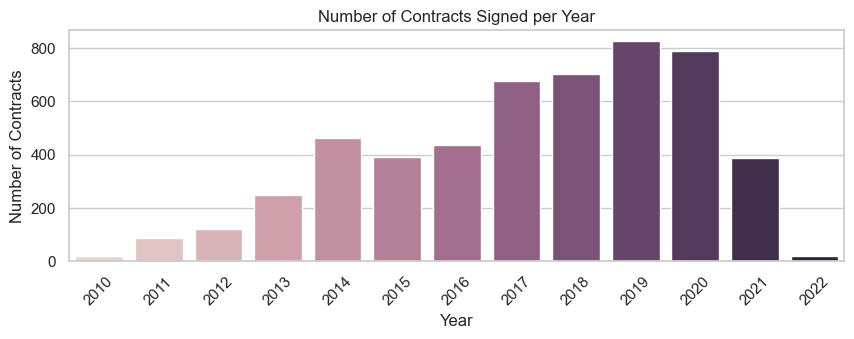

In [222]:
# Plot the number of contracts signed per year
plt.figure(figsize=(10, 3))
sns.barplot(x=signing_year.index, y=signing_year.values, hue=signing_year.index, dodge=False, legend=False)
plt.title('Number of Contracts Signed per Year')
plt.xlabel('Year')
plt.ylabel('Number of Contracts')
plt.xticks(rotation=45)
plt.show()

The distribution by month is very similar to the Publications per Year variable

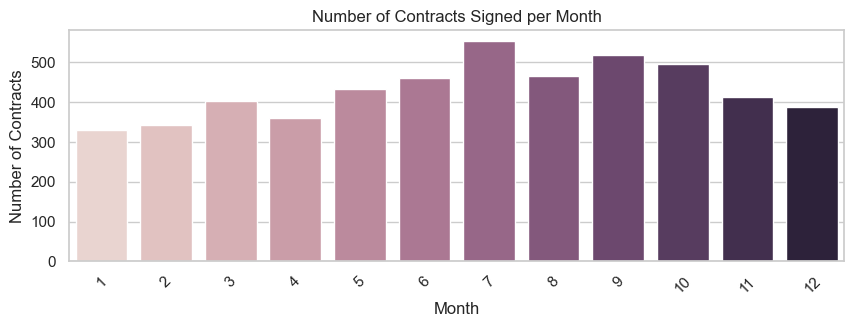

In [223]:
plt.figure(figsize=(10, 3))
sns.barplot(x=signing_month.index, y=signing_month.values, hue=signing_month.index, dodge=False, legend=False)
plt.title('Number of Contracts Signed per Month')
plt.xlabel('Month')
plt.ylabel('Number of Contracts')
plt.xticks(rotation=45)
plt.show()

July stands out as the month with the most Signing Dates, but almost all months have the same values, there are no particular peaks.

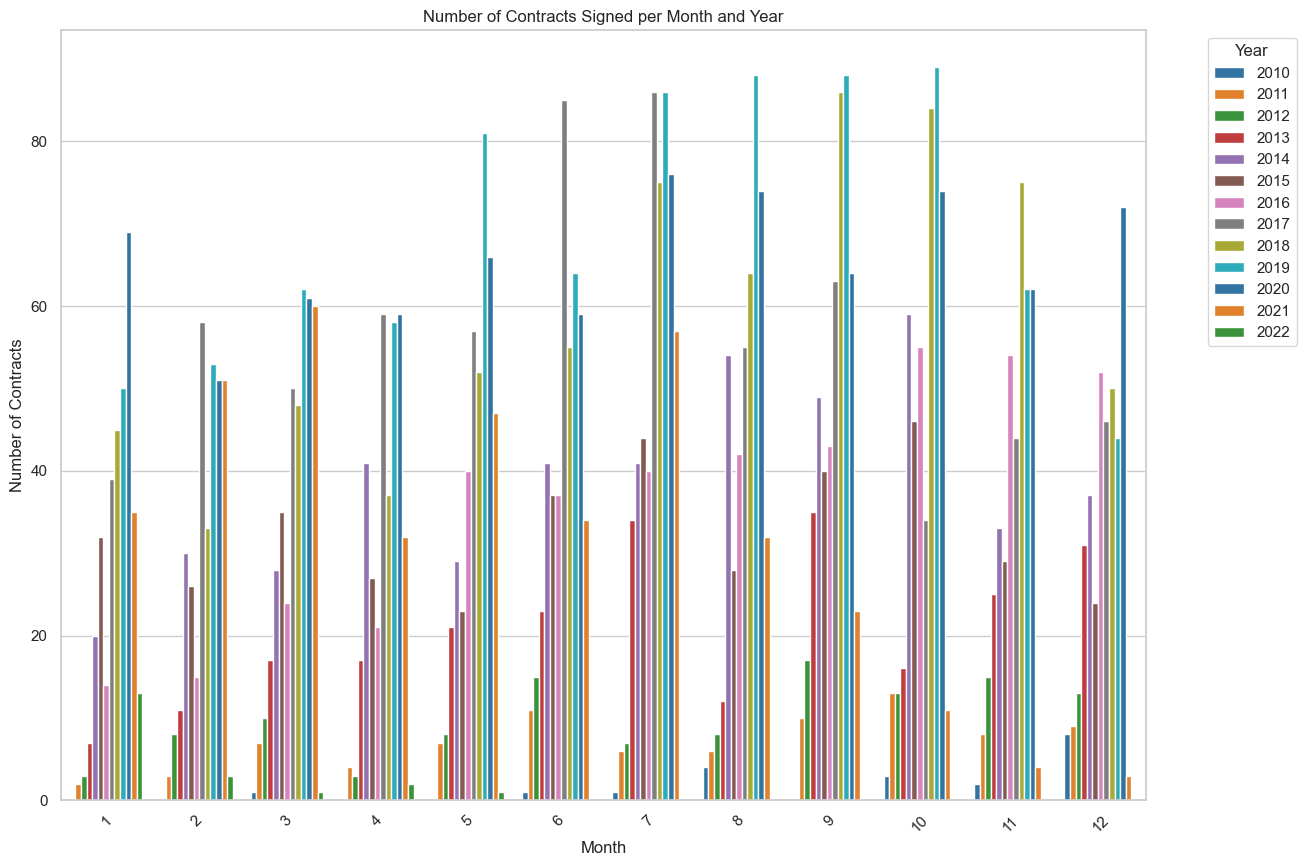

In [224]:
plt.figure(figsize=(14, 10))
years = sorted(df1['Signing Year'].unique())
sns.countplot(x='Signing Month', hue='Signing Year', data=df1, hue_order=years, palette='tab10')
plt.title('Number of Contracts Signed per Month and Year')
plt.xlabel('Month')
plt.ylabel('Number of Contracts')
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.show()

The higher values for **July** found in the previous graph are confirmed with this graph where for each year there are higher values for July than for the other months.

Furthermore, for each month, except for a few outlier values (December for the year 2020), it is observed that the data follow the same distribution for all years, showing a certain **cyclicity**.

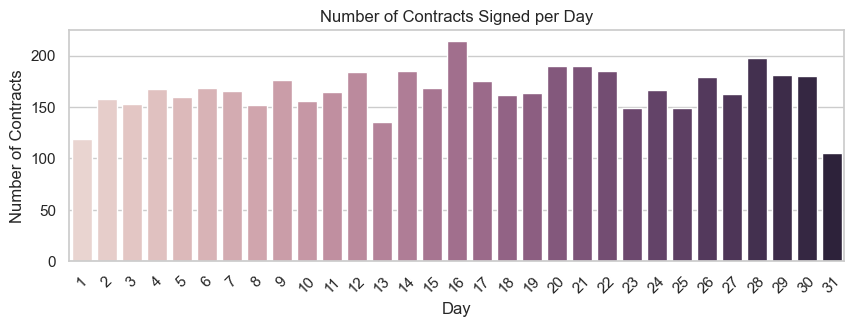

In [225]:
plt.figure(figsize=(10, 3))
sns.barplot(x=signing_day.index, y=signing_day.values, hue=signing_day.index, dodge=False, legend=False)
plt.title('Number of Contracts Signed per Day')
plt.xlabel('Day')
plt.ylabel('Number of Contracts')
plt.xticks(rotation=45)
plt.show()

Almost all days follow the same distribution, peaking on the 16th of each month.

#### Closing date

In [226]:
# Convert the 'Closing date' column to datetime format
df1['Closing date'] = pd.to_datetime(df1['Closing date'], format='%d-%m-%Y')

# Extract the year, month, and day from the 'Closing date' column
df1['Closing Date Year'] = df1['Closing date'].dt.year
df1['Closing Date Month'] = df1['Closing date'].dt.month
df1['Closing Date Day'] = df1['Closing date'].dt.day

closing_year = df1['Closing Date Year'].value_counts(dropna=False)
closing_month = df1['Closing Date Month'].value_counts(dropna=False)
closing_day = df1['Closing Date Day'].value_counts(dropna=False)

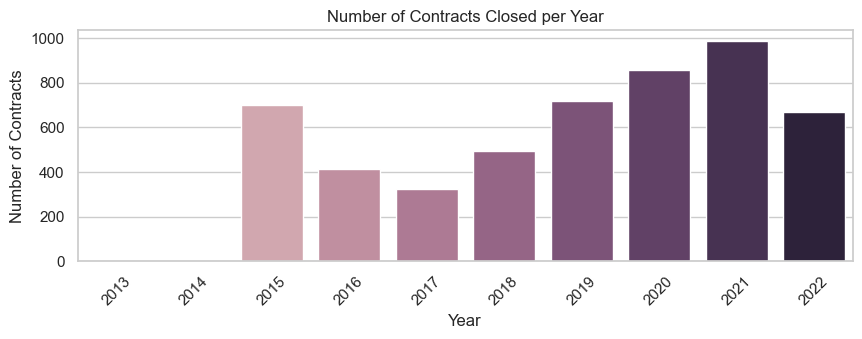

In [227]:
# Plot the number of contracts closed per year
plt.figure(figsize=(10, 3))
sns.barplot(x=closing_year.index, y=closing_year.values, hue=closing_year.index, dodge=False, legend=False)
plt.title('Number of Contracts Closed per Year')
plt.xlabel('Year')
plt.ylabel('Number of Contracts')
plt.xticks(rotation=45)
plt.show()

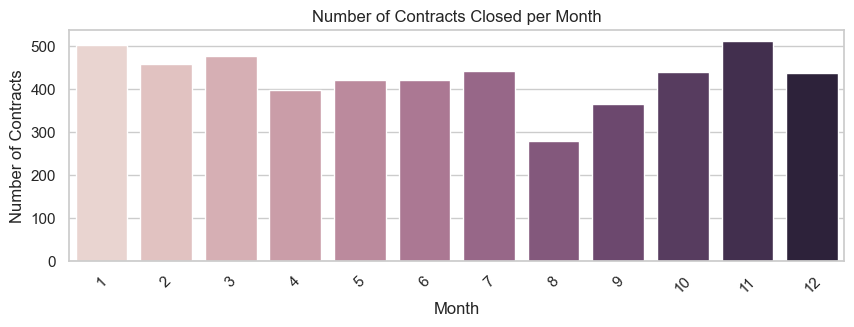

In [228]:
# Plot the number of contracts closed per month
plt.figure(figsize=(10, 3))
sns.barplot(x=closing_month.index, y=closing_month.values, hue=closing_month.index, dodge=False, legend=False)
plt.title('Number of Contracts Closed per Month')
plt.xlabel('Month')
plt.ylabel('Number of Contracts')
plt.xticks(rotation=45)
plt.show()

In January and November there is an increase in contract closures. While the minimum is recorded in August.

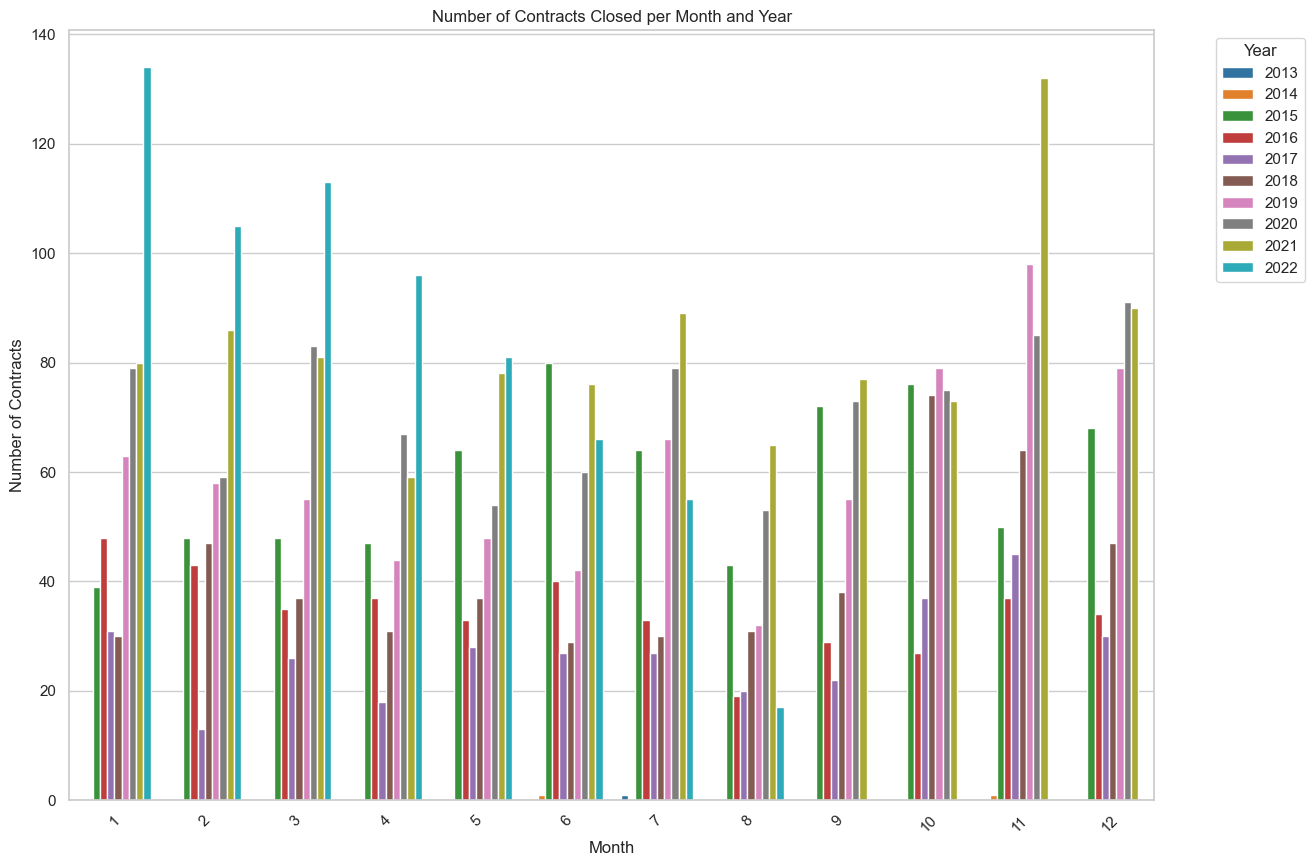

In [229]:
# Plot the number of contracts closed per day
plt.figure(figsize=(14, 10))
years = sorted(df1['Closing Date Year'].unique())
sns.countplot(x='Closing Date Month', hue='Closing Date Year', data=df1, hue_order=years, palette='tab10')
plt.title('Number of Contracts Closed per Month and Year')
plt.xlabel('Month')
plt.ylabel('Number of Contracts')
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.show()

Here we show what we found with the previous graph

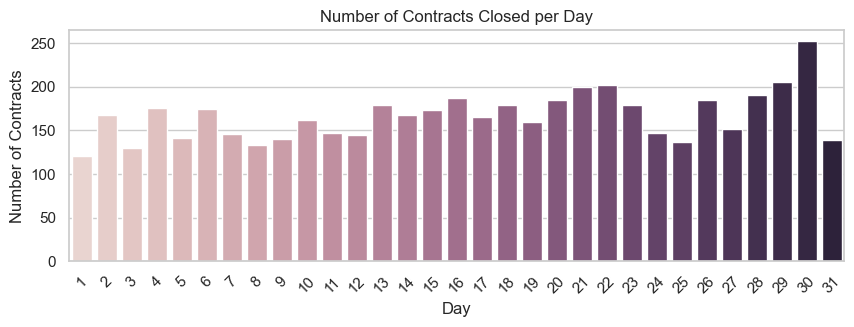

In [230]:
plt.figure(figsize=(10, 3))
sns.barplot(x=closing_day.index, y=closing_day.values, hue=closing_day.index, dodge=False, legend=False)
plt.title('Number of Contracts Closed per Day')
plt.xlabel('Day')
plt.ylabel('Number of Contracts')
plt.xticks(rotation=45)
plt.show()

As one might expect, the days at the end of the month have the highest values

In [231]:
df1.drop(columns=['Signing date', 'Closing date'], inplace=True)

### Integer

In [232]:
df1.drop(columns=['Count', 'ID'], inplace=True)

#### District Code

In [233]:
df1['District'] = df1['District'].str.strip()

In [234]:
df1.groupby('District Code')['District'].nunique()

District Code
1.0     1
2.0     1
3.0     1
4.0     1
5.0     1
6.0     1
7.0     1
8.0     1
9.0     1
10.0    1
11.0    1
12.0    1
13.0    3
14.0    1
15.0    1
16.0    1
17.0    1
18.0    1
19.0    1
20.0    1
Name: District, dtype: int64

In [235]:
df1.groupby('District')['District Code'].nunique()

District
Aveiro                        1
Beja                          2
Braga                         1
Bragança                      1
Castelo Branco                1
Coimbra                       1
Faro                          2
Guarda                        1
Leiria                        1
Lisboa                        1
Portalegre                    1
Porto                         1
Região Autónoma da Madeira    1
Região Autónoma dos Açores    1
Santarém                      1
Setúbal                       1
Viana do Castelo              1
Vila Real                     1
Viseu                         1
Évora                         1
Name: District Code, dtype: int64

There might be some input problems because code 13 is assigned to 3 different districts

In [236]:
districts_with_multiple_codes = df1.groupby('District')['District Code'].nunique()
districts_with_multiple_codes = districts_with_multiple_codes[districts_with_multiple_codes > 1]
df1[df1['District'].isin(districts_with_multiple_codes.index)][['District', 'District Code']].drop_duplicates()

District  District Code
2        Faro            8.0
33       Beja            2.0
5205     Beja           13.0
5206     Faro           13.0

In [237]:
print(df1[(df1['District'] == 'Beja') & (df1['District Code'] == 13)].shape[0])
print(df1[(df1['District'] == 'Faro') & (df1['District Code'] == 13)].shape[0])

1
1


There was probably an insertion error here, so since there are only two records, I would remove them to avoid introducing outliers.

In [238]:
# Remove records with the specified condition
print(f'Before remove: {df1.shape[0]}')
df1 = df1[~((df1['District'] == 'Beja') & (df1['District Code'] == 13))]
df1 = df1[~((df1['District'] == 'Faro') & (df1['District Code'] == 13))]
print(f'After remove: {df1.shape[0]}')

Before remove: 5166
After remove: 5164


In [239]:
print((df1.groupby('District')['District Code'].nunique() == 1).all())
print((df1.groupby('District Code')['District'].nunique() == 1).all())

True
True


In [240]:
df1.drop(columns=['District Code'], inplace=True)

#### Submission Deadline

In [241]:
df1['Submission deadline (days)'].isna().sum()

254

With regard to the NaN values present, here too I would like to use an inputer, so I wait before processing all the other features and then return to it.

#### Difference between the close and signing dates

In [242]:
print(df1['Diference between close and signing dates'].isna().sum())

0


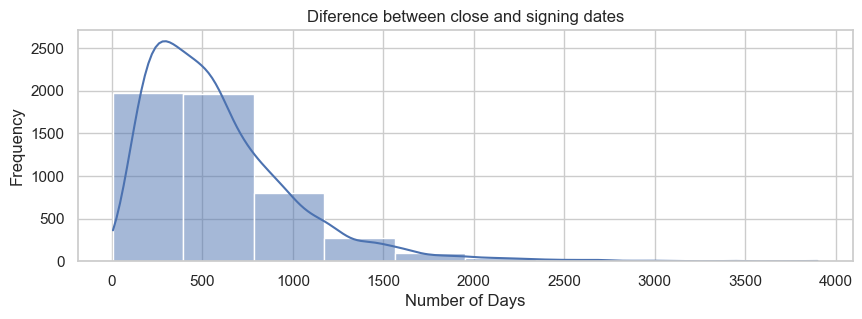

In [243]:
plt.figure(figsize=(10, 3))
sns.histplot(df1['Diference between close and signing dates'].dropna(), bins=10, kde=True)
plt.title('Diference between close and signing dates')
plt.xlabel('Number of Days')
plt.ylabel('Frequency')
plt.show()

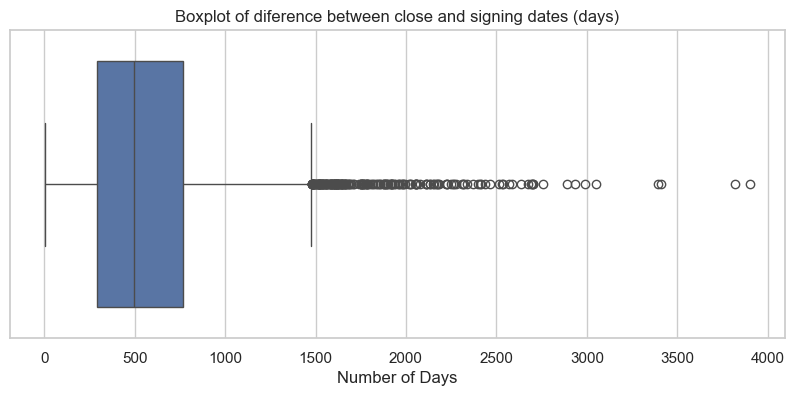

In [244]:
plt.figure(figsize=(10, 4))
sns.boxplot(x=df1['Diference between close and signing dates'])
plt.title('Boxplot of diference between close and signing dates (days)')
plt.xlabel('Number of Days')
plt.show()

We apply the same reasoning for the previous feature, here we remove the extreme outliers and binarise with Equal Depth.

In [245]:
# Rilevare e categorizzare gli outlier
df1 = df1.reset_index(drop=True)
result_dataset = detect_and_categorize_outliers(df1, 'Diference between close and signing dates')['outlier_category']
idx = result_dataset[(result_dataset == 'extreme outlier above') | (result_dataset == 'extreme outlier below')].index
print(f"Number of average and extreme outliers: {len(idx)}")
df1 = df1.drop(index=idx)
df1, bins = discretize(df1, 'Diference between close and signing dates', n_bins=3, strategy='quantile', print_bins=True)

Number of average and extreme outliers: 22


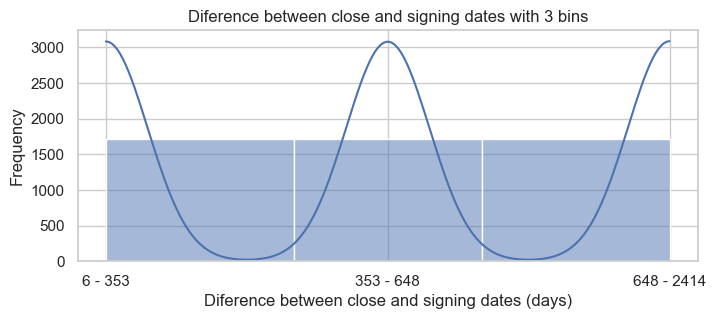

In [246]:
plt.figure(figsize=(8, 3))
sns.histplot(df1['Diference between close and signing dates'], bins=3, kde=True)
plt.xticks(ticks=np.arange(3), labels=[f"{int(bins[i])} - {int(bins[i+1])}" for i in range(len(bins) - 1)])
plt.title('Diference between close and signing dates with 3 bins')
plt.xlabel('Diference between close and signing dates (days)')
plt.ylabel('Frequency')
plt.show()

In [247]:
df1['Diference between close and signing dates'] = df1['Diference between close and signing dates'].replace({0.0: 'Few Days', 1.0: 'Medium Days', 2.0: 'Many Days'})

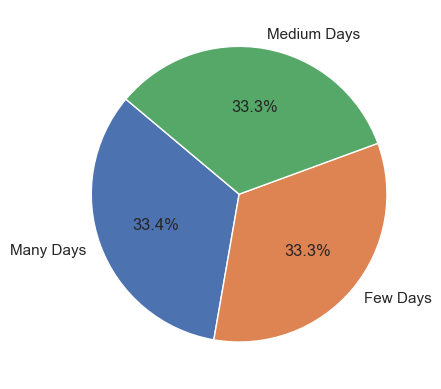

In [248]:
plt.pie(df1['Diference between close and signing dates'].value_counts(), labels=df1['Diference between close and signing dates'].value_counts().index, autopct='%1.1f%%', startangle=140);

#### Execution deadline (days)

In [249]:
df1['Execution deadline (days)'].value_counts(dropna=False)

Execution deadline (days)
120    695
180    686
90     599
365    410
150    393
      ... 
306      1
163      1
657      1
333      1
96       1
Name: count, Length: 232, dtype: int64

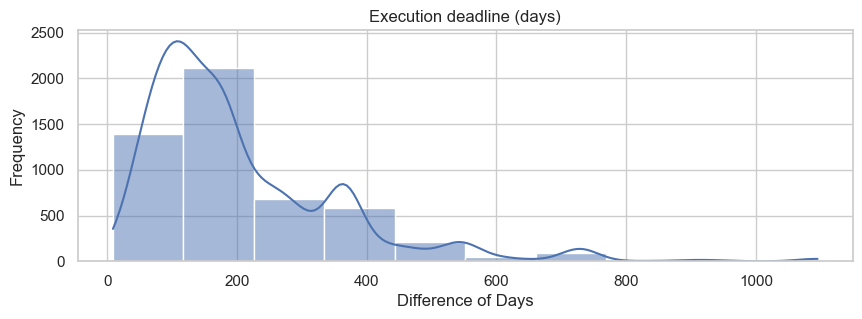

In [250]:
plt.figure(figsize=(10, 3))
sns.histplot(df1['Execution deadline (days)'].dropna(), bins=10, kde=True)
plt.title('Execution deadline (days)')
plt.xlabel('Difference of Days')
plt.ylabel('Frequency')
plt.show()

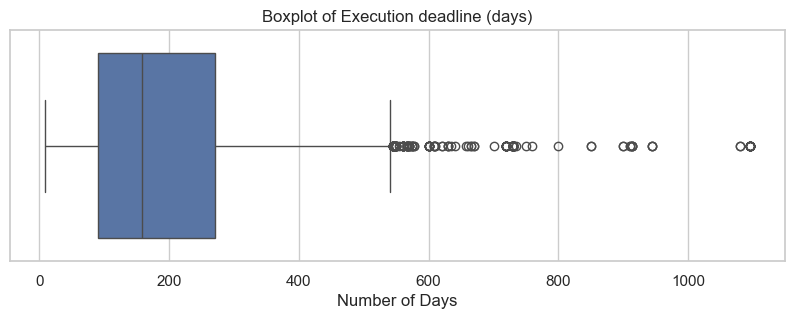

In [251]:
plt.figure(figsize=(10, 3))
sns.boxplot(x=df1['Execution deadline (days)'])
plt.title('Boxplot of Execution deadline (days)')
plt.xlabel('Number of Days')
plt.show()

I only remove extreme outliers

In [252]:
# Find and categorize outliers
df1 = df1.reset_index(drop=True)
result_dataset = detect_and_categorize_outliers(df1, 'Execution deadline (days)')['outlier_category']
idx = result_dataset[(result_dataset == 'extreme outlier above') | (result_dataset == 'extreme outlier below')].index
print(f"Number of average and extreme outliers: {len(idx)}")
df1 = df1.drop(index=idx)
df1, bins = discretize(df1, 'Execution deadline (days)', n_bins=3, strategy='quantile', print_bins=True)

Number of average and extreme outliers: 26


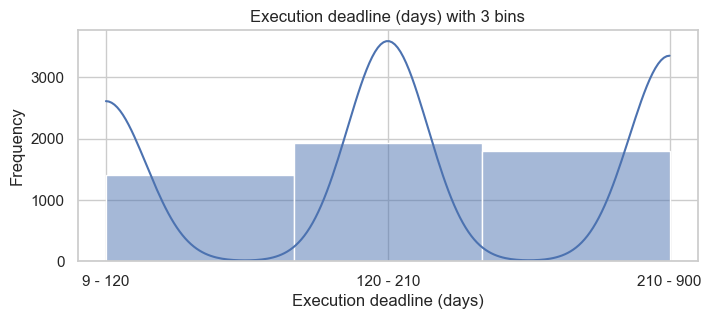

In [253]:
plt.figure(figsize=(8, 3))
sns.histplot(df1['Execution deadline (days)'], bins=3, kde=True)
plt.xticks(ticks=np.arange(3), labels=[f"{int(bins[i])} - {int(bins[i+1])}" for i in range(len(bins) - 1)])
plt.title('Execution deadline (days) with 3 bins')
plt.xlabel('Execution deadline (days)')
plt.ylabel('Frequency')
plt.show()

In [254]:
df1['Execution deadline (days)'] = df1['Execution deadline (days)'].replace({0.0: 'Short Deadline', 1.0: 'Medium Deadline', 2.0: 'Long Deadline'})

#### Award Criteria Class

In [255]:
df1['Award criteria class'].value_counts(dropna=False)

Award criteria class
2    2328
0    1502
1    1286
Name: count, dtype: int64

1 - Multifactor Criterion; 2 - Lowest Price Criterion; 0 - Missing Award Criterion

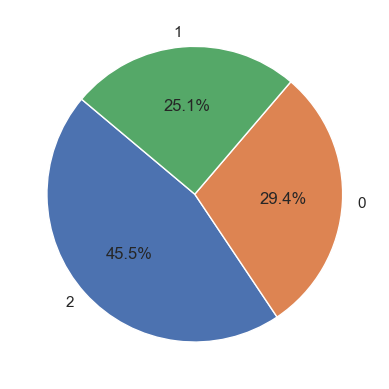

In [256]:
plt.pie(df1['Award criteria class'].value_counts(), labels=df1['Award criteria class'].value_counts().index, autopct='%1.1f%%', startangle=140);

The Lowest Price Criterion seems to have the majority of values.

#### Number of bidders

For the semantics of this feature, binarising could condense the information too much and lose some of it, so here I would avoid binarising but leave the feature as it is.

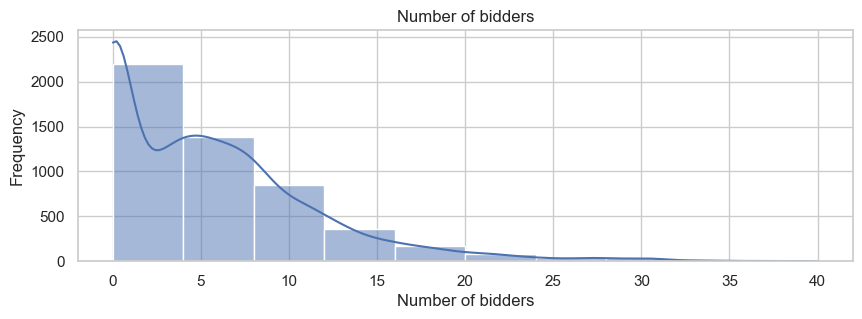

In [257]:
plt.figure(figsize=(10, 3))
sns.histplot(df1['Number of bidders'].dropna(), bins=10, kde=True)
plt.title('Number of bidders')
plt.xlabel('Number of bidders')
plt.ylabel('Frequency')
plt.show()

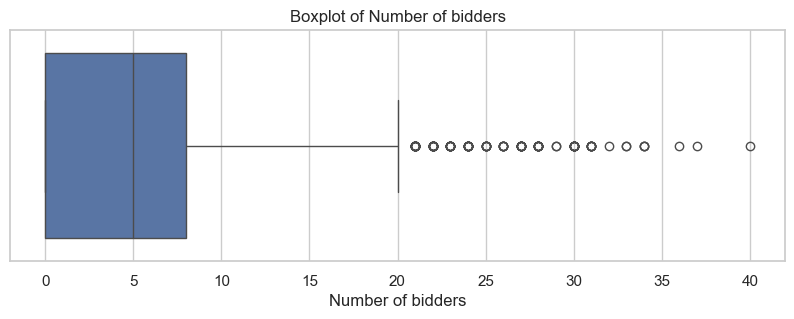

In [258]:
plt.figure(figsize=(10, 3))
sns.boxplot(x=df1['Number of bidders'])
plt.title('Boxplot of Number of bidders')
plt.xlabel('Number of bidders')
plt.show()

In [259]:
df1 = df1.reset_index(drop=True)
result_dataset = detect_and_categorize_outliers(df1, 'Number of bidders')['outlier_category']
idx = result_dataset[(result_dataset == 'extreme outlier above') | (result_dataset == 'extreme outlier below')].index
print(f"Number of average and extreme outliers: {len(idx)}")

Number of average and extreme outliers: 2


### Float

#### Base Bid Price

In [260]:
df1['Base Bid Price (€)'].describe()

count    5.116000e+03
mean     8.301420e+05
std      2.667100e+06
min      7.750000e+03
25%      2.001600e+05
50%      3.350000e+05
75%      6.746250e+05
max      1.100000e+08
Name: Base Bid Price (€), dtype: float64

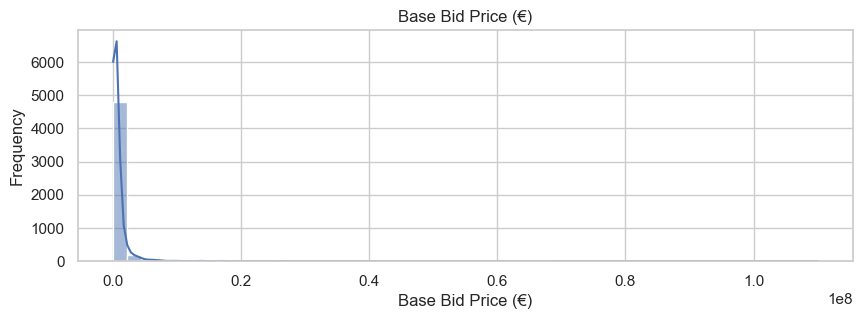

In [261]:
plt.figure(figsize=(10, 3))
sns.histplot(df1['Base Bid Price (€)'], bins=50, kde=True)
plt.title('Base Bid Price (€)')
plt.xlabel('Base Bid Price (€)')
plt.ylabel('Frequency')
plt.show()

In [262]:
df1, bins = discretize(df1, 'Base Bid Price (€)', n_bins=3, strategy='quantile', print_bins=True, keep_old=True)

Here again I decide to use equal depth because there are a few outliers, and I decide to have only 3 bins to be able to classify the amount of contracts: low, medium, high price.

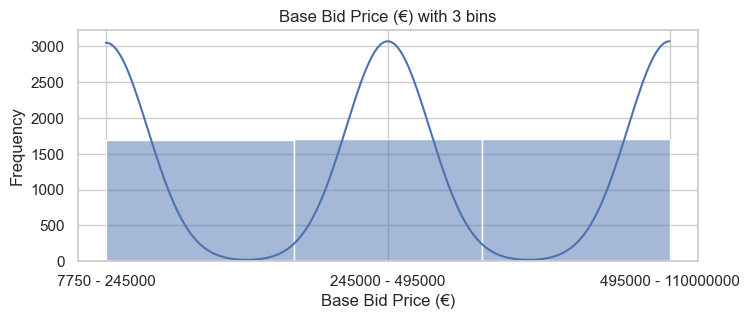

In [263]:
plt.figure(figsize=(8, 3))
sns.histplot(df1['Base Bid Price (€)'], bins=3, kde=True)
plt.xticks(ticks=np.arange(3), labels=[f"{int(bins[i])} - {int(bins[i+1])}" for i in range(len(bins) - 1)])
plt.title(f'Base Bid Price (€) with 3 bins')
plt.xlabel('Base Bid Price (€)')
plt.ylabel('Frequency')
plt.show()

In [264]:
df1['Base Bid Price (€)'] = df1['Base Bid Price (€)'].replace({0.0: 'Low Price', 1.0: 'Medium Price', 2.0: 'High Price'})

#### Effective Price Class

We generate a feature called Effective Price Class using the same criteria as for Initial Price Class, so we have both the numerical and categorical value and then we can decide to remove either one for analysis.

In [265]:
bins = [0, 250000, 1000000, float('inf')]
labels = [1, 2, 3]

# Discretize the 'Effective Price (€)' column with 3 bins
df1['E. price Class'] = pd.cut(df1['Effective Price (€)'], bins=bins, labels=labels, right=False)
df1['E. price Class'] = df1['E. price Class'].astype('Int64')

In [266]:
(len(df1[df1['E. price Class'] != df1['I. price Class']])/df1.shape[0])*100

3.440187646598905

3% of the values changed

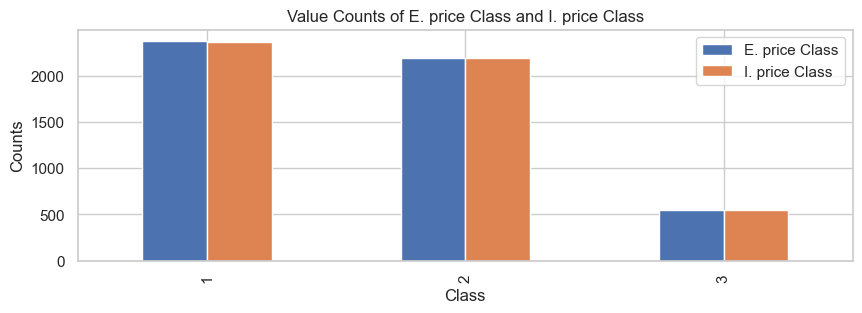

In [267]:
e_price_class_counts = df1['E. price Class'].value_counts()
i_price_class_counts = df1['I. price Class'].value_counts()
value_counts_df = pd.DataFrame({
    'E. price Class': e_price_class_counts,
    'I. price Class': i_price_class_counts
})

# Plotting
value_counts_df.plot(kind='bar', figsize=(10, 3))
plt.title('Value Counts of E. price Class and I. price Class')
plt.xlabel('Class')
plt.ylabel('Counts')
plt.show()

The actual price has not shifted much at class level compared to the initial price

#### Difference between the effective and initial price (€)

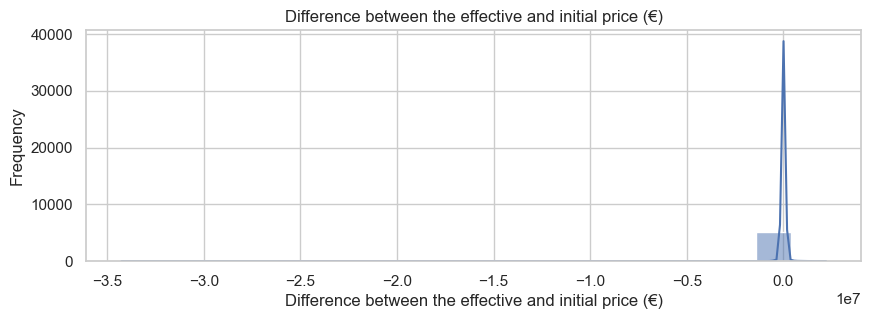

In [268]:
plt.figure(figsize=(10, 3))
sns.histplot(df1['Difference between the effective and initial price (€)'], bins=20, kde=True)
plt.title('Difference between the effective and initial price (€)')
plt.ylabel('Frequency')
plt.show()

In [269]:
(df1[df1['Difference between the effective and initial price (€)'] == 0.00].shape[0]/df1.shape[0])*100

31.56763096168882

In [270]:
df1['Difference between the effective and initial price (€)'].describe()

count    5.116000e+03
mean    -2.658470e+03
std      4.907840e+05
min     -3.425575e+07
25%     -3.600192e+03
50%      0.000000e+00
75%      4.808232e+03
max      2.202360e+06
Name: Difference between the effective and initial price (€), dtype: float64

In [271]:
df2 = df1.copy()
df2, bins = discretize(df2, 'Difference between the effective and initial price (€)', n_bins=3, strategy='quantile', print_bins=True)

Here, too, I used equal depth discretisation because of outliers

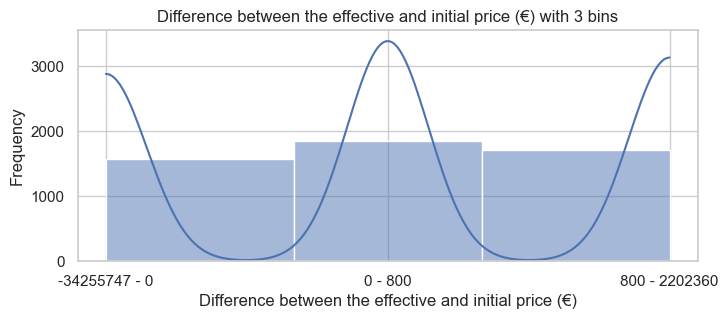

In [272]:
plt.figure(figsize=(8, 3))
sns.histplot(df2['Difference between the effective and initial price (€)'], bins=3, kde=True)
plt.xticks(ticks=np.arange(3), labels=[f"{int(bins[i])} - {int(bins[i+1])}" for i in range(len(bins) - 1)])
plt.title('Difference between the effective and initial price (€) with 3 bins')
plt.xlabel('Difference between the effective and initial price (€)')
plt.ylabel('Frequency')
plt.show()

In [273]:
df1['Difference between the effective and initial price class'] = df2['Difference between the effective and initial price (€)']
df1['Difference between the effective and initial price class'] = df1['Difference between the effective and initial price class'].replace({0.0: 'Low Difference', 1.0: 'Medium Difference', 2.0: 'High Difference'})

#### Classification of the multifactor criteria (%)

In [274]:
df1['Classification of the multifactor criteria (%)'].describe()

count    5115.000000
mean       60.118964
std        42.829082
min         0.000000
25%         0.000000
50%        70.000000
75%       100.000000
max       100.000000
Name: Classification of the multifactor criteria (%), dtype: float64

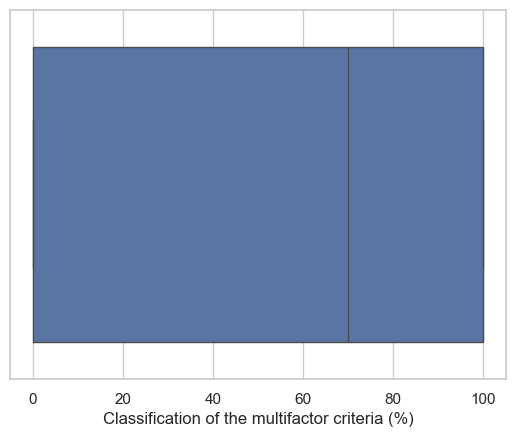

In [275]:
sns.boxplot(x='Classification of the multifactor criteria (%)', data=df1);

Here I would avoid binarising because we are interested in specific weight, it gives us a broader view.

### Text

For columns with free text, I will use the **TF-IDF** approach. This method allows the syntax of the words to be analysed, but does not capture the semantics. <br> 
Capturing semantics would require a more complex process involving the use of **Embeddings** or models such as **BERT**, techniques that have not been covered in this Data Mining course. <br>
Consequently, I will avoid using them, but it might be interesting to explore them in the future to see if they can be improved.

Eliminating superfluous columns

In [276]:
df1.drop(columns=['Short Description1', 'Country', 'Award criteria'], inplace=True)

#### Municipality

In [277]:
df1['Municipality'].value_counts(dropna=False)

Municipality
 Lisboa                  252
NaN                      166
 Porto                   138
 Leiria                  135
 Santa Maria da Feira    109
                        ... 
 Pedrogão Grande           1
 Trancoso                  1
 Fornos de Algodres        1
 Proença-a-Nova            1
 Monforte                  1
Name: count, Length: 281, dtype: int64

In [278]:
df1['Municipality'] = df1['Municipality'].str.strip()

For NaN values, I would avoid making a fill because in custer analysis this is a central parameter, so to avoid introducing bias, given also the low number of NaN values (166) I would proceed to remove them directly.

In [279]:
df1 = df1.dropna(subset=['Municipality'])

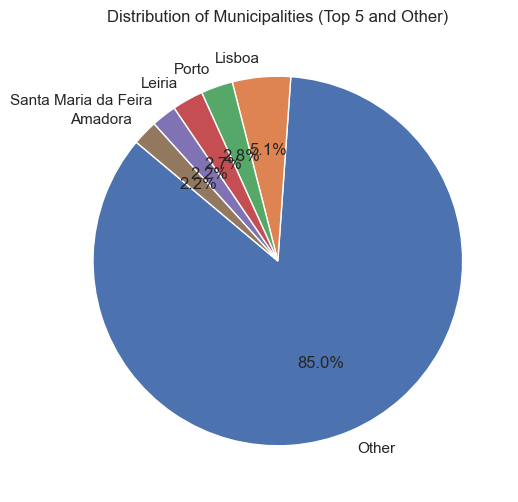

In [280]:
# Combine top 10 labels with 'Other'
top_5 = df1['Municipality'].value_counts().head(5)
municipality_counts = df1['Municipality'].apply(lambda x: x if x in top_5.index else 'Other').value_counts()
# Plot the pie chart
plt.figure(figsize=(10, 6))
plt.pie(municipality_counts, labels=municipality_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Municipalities (Top 5 and Other)')
plt.show()

C:\Users\dommy\AppData\Local\Temp\ipykernel_13992\3972463536.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_20.values, y=top_20.index, palette='viridis');


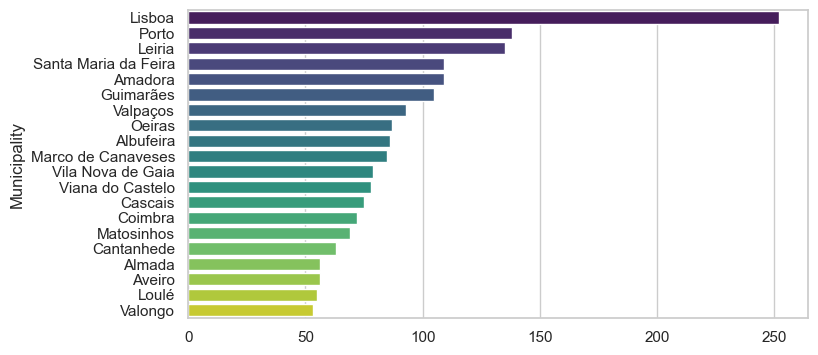

In [281]:
top_20 = df1['Municipality'].value_counts().head(20)
plt.figure(figsize=(8, 4))
sns.barplot(x=top_20.values, y=top_20.index, palette='viridis');

#### District

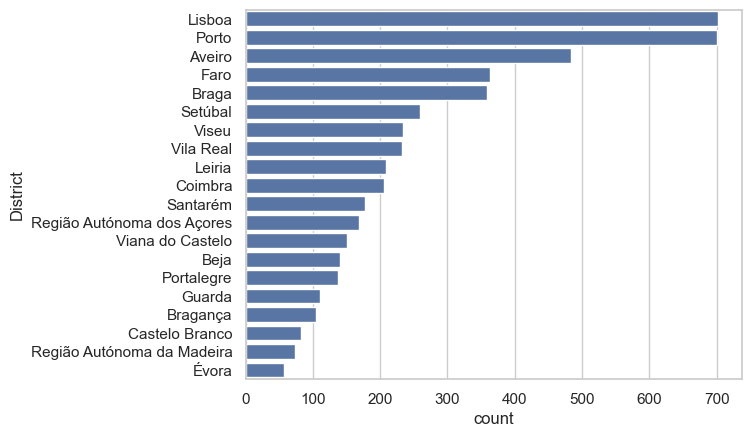

In [282]:
sns.countplot(y='District', data=df1, order=df1['District'].value_counts().index);

Porto and Lisbon seem to be the districts with the most contracts

#### Collateral

In [283]:
df1['Collateral'].value_counts(dropna=False)

Collateral
NaN                2684
5                   929
Yes (no values)     453
No                  423
 5\n \n             334
10                   50
2                    21
Waive                19
 2\n \n               8
3                     7
4                     7
 10\n \n              6
 4\n \n               3
 3\n \n               2
 5 \n                 1
5\n \n                1
15                    1
 6\n \n               1
Name: count, dtype: int64

More than 50% of the values are null, so this feature is not very informative and I decide to remove it.

In [284]:
df1.drop(columns=['Collateral'], inplace=True)

#### Contract end type

In [285]:
df1['Contract end type'].value_counts(dropna=False)

Contract end type
Complete fulfillment of the contract                                                   4916
Non-fulfilment of the contract (Contract Termination)                                    21
Non-fulfilment of the contract (Revocation of the Contract)                               9
NaN                                                                                       1
Non-fulfilment of Contract (Object of refusal of approval by the Court of Auditors)       1
Non-fulfilment of contract (Cancelled or declared void)                                   1
Complete fulfillment of the contract+AE4166                                               1
Name: count, dtype: int64

It is a feature that is too under-represented, about 0.6% represents the Non-fulfilment of Contract, this variable fails to make a significant contribution, so I decide to remove it.

In [286]:
df1.drop(columns=['Contract end type'], inplace=True)

#### Cpvs Designation

Pre-processing of the text by removing stopwords, punctuation, lemmatising and removing verbs, finally tokenizing.

In [287]:
df1['Cpvs Designation Cleaned'] = df1['Cpvs Designation'].apply(preprocess_text)

In order to be able to extract the most significant keywords, I decide to use TF-IDF, so that I can create a Bag-of-words and choose keywords that are not too common but not too rare either.

**TF-IDF Matrix for Keyword Extraction**

The TF-IDF matrix is obtained by considering two factors:

1. **Term Frequency (TF)**: Measures how often a word appears in a document relative to the total number of words in that document. The more frequently a word appears in a document, the higher its TF value.
   
   - Formula: 
     $$
     \text{TF}(t, d) = \frac{\text{Number of occurrences of term } t \text{ in document } d}{\text{Total number of terms in document } d}
     $$

2. **Inverse Document Frequency (IDF)**: Reduces the weight of overly common words that appear in many documents. Words that appear in fewer documents receive a higher IDF value, making them more relevant for distinguishing between documents.

   - Formula:
     $$
     \text{IDF}(t) = \log \left( \frac{\text{Total number of documents}}{\text{Number of documents containing the term } t} \right)
     $$

The **TF-IDF** score for each word in a document is given by the product of TF and IDF:

$$
\text{TF-IDF}(t, d) = \text{TF}(t, d) \times \text{IDF}(t)
$$

The resulting matrix has the following dimensions:
- **Rows**: Each row represents a document (in our case, a record from the dataset).
- **Columns**: Each column represents a unique word (the vocabulary).
- **Cells**: The cell value represents the TF-IDF score of the word for that document.

This approach allows for identifying the most relevant **keywords**, which are neither too common nor too rare, helping to build a meaningful Bag of Words.

I extract the **top global keywords** independently of the CPVS code, to obtain a set of keywords representing the entire corpus.

**Tfidf Parameters**:
- **Min_df = 0.03**: I set a lower bound to include only keywords that appear in at least 3% of the documents, ensuring that the selected words are relevant to the dataset.
- **Max_df = 0.8**: I exclude keywords that appear in more than 80% of the documents to avoid including overly common terms.
- **Max_features = 10**: I select the top 10 keywords to have a concise and representative set.
- **Ngram_range = (2, 3)**: Since we are dealing with codes and different types of work, I chose to represent bigrams and trigrams to capture both the adjective and the type of work being performed.

In [288]:
vectorizer = vectorizer = TfidfVectorizer(min_df=0.03, max_df=0.8, ngram_range=(2, 3), max_features=10)
X = vectorizer.fit_transform(df1['Cpvs Designation Cleaned'])
X.shape
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_df.head()

construction work  construction work water  engineering work  \
0            0.33147                 0.669823               0.0   
1            0.00000                 0.000000               0.0   
2            0.00000                 0.000000               0.0   
3            1.00000                 0.000000               0.0   
4            1.00000                 0.000000               0.0   

   refurbishment work  surface work  surface work road  various surface  \
0                 0.0           0.0                0.0              0.0   
1                 0.0           0.0                0.0              0.0   
2                 0.0           0.0                0.0              0.0   
3                 0.0           0.0                0.0              0.0   
4                 0.0           0.0                0.0              0.0   

   various surface work  work road  work water  
0                   0.0        0.0    0.664428  
1                   0.0        0.0    0.000000  
2                   0.0        0.0    0.000000  
3                   0.0        0.0    0.000000  
4                   0.0        0.0    0.000000

In [289]:
keyword_list_cpvs = tfidf_df.columns.to_list()
# Add the keywords as new columns
for keyword in keyword_list_cpvs:
    df1[keyword] = df1['Cpvs Designation Cleaned'].apply(lambda x: 1 if keyword in x.lower() else 0)

df1.head()

Cpvs                                   Cpvs Designation  \
0              45231300-8   Construction work for water and sewage pipelines   
1              45212290-5  Repair and maintenance work in connection with...   
2              45262330-3                               Concrete repair work   
3  45000000-7, 45221119-9  Construction work, Bridge renewal construction...   
4              45221119-9                   Bridge renewal construction work   

   Environmental criteria (T/F) Publication Year Close Year Municipality  \
0                             0             2020       2022       Almada   
1                             0             2020       2022        Viseu   
2                             0             2022       2022        Loulé   
3                             0             2020       2022        Viseu   
4                             0             2021       2022        Viseu   

  District  Submission deadline (days)  \
0  Setúbal                        30.0   
1    Viseu                         NaN   
2     Faro                        28.0   
3    Viseu                        19.0   
4    Viseu                        15.0   

  Diference between close and signing dates Execution deadline (days)  ...  \
0                               Medium Days             Long Deadline  ...   
1                               Medium Days            Short Deadline  ...   
2                                  Few Days            Short Deadline  ...   
3                               Medium Days            Short Deadline  ...   
4                                  Few Days            Short Deadline  ...   

  construction work  construction work water  engineering work  \
0                 1                        1                 0   
1                 0                        0                 0   
2                 0                        0                 0   
3                 1                        0                 0   
4                 1                        0                 0   

   refurbishment work  surface work  surface work road  various surface  \
0                   0             0                  0                0   
1                   0             0                  0                0   
2                   0             0                  0                0   
3                   0             0                  0                0   
4                   0             0                  0                0   

   various surface work  work road  work water  
0                     0          0           1  
1                     0          0           0  
2                     0          0           0  
3                     0          0           0  
4                     0          0           0  

[5 rows x 43 columns]

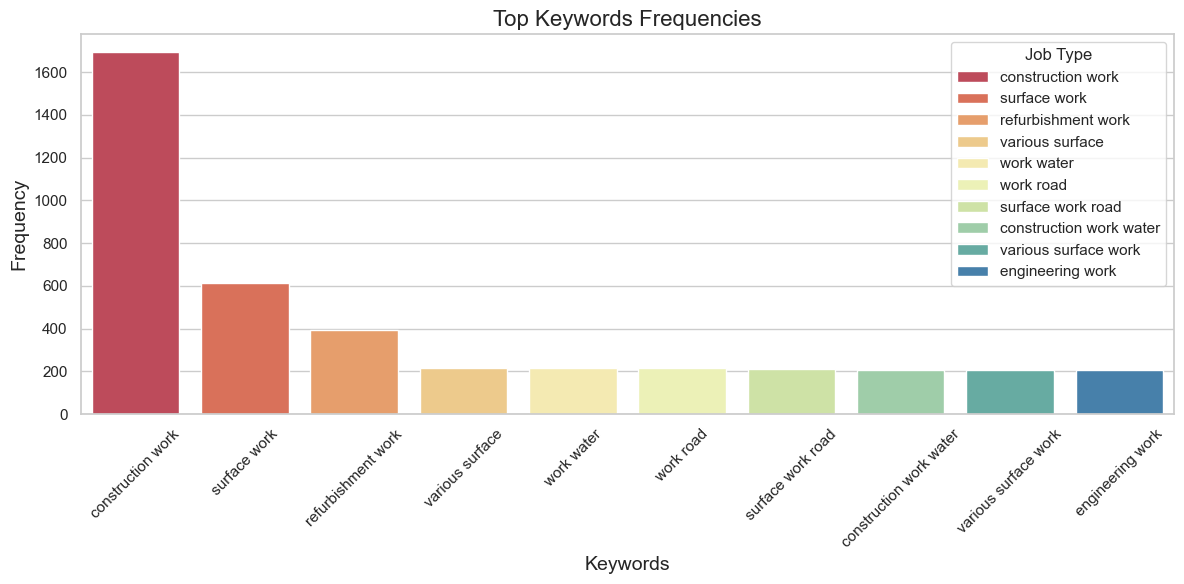

In [290]:
keyword_sums = df1[keyword_list_cpvs].sum().sort_values(ascending=False).reset_index()
keyword_sums.columns = ['Keyword', 'Frequency']

keyword_sums['Job Type'] = keyword_sums['Keyword'].apply(lambda x: x.split('_')[0])

plt.figure(figsize=(12, 6))
sns.barplot(data=keyword_sums, x='Keyword', y='Frequency', palette="Spectral", hue='Job Type', legend=True)

plt.title('Top Keywords Frequencies', fontsize=16)
plt.xlabel('Keywords', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [291]:
df1[(df1[keyword_list_cpvs] == 0).all(axis=1)].shape[0]

2069

The selected keywords prove to be representative and cover a wide range of scenarios. The distribution of frequency of occurrence for each keyword ensures good coverage in different contexts, as evidenced by the most frequent keywords.

It is normal to find some rows with all zero values for these keywords, as we are dealing with different types of CPVS, including several unique ones.

In [292]:
df1.drop(columns=['Cpvs Designation Cleaned', 'Cpvs', 'Cpvs Designation', 'Cpvs Designation Cleaned', 'outlier_category'], inplace=True)

#### Justification for deadline change

Here again I try to use the TF-IDF matrix approach.

In [293]:
df1['Justification for deadline change'].fillna('Not Specified', inplace=True)
df1['Justification for deadline change Cleaned'] = df1['Justification for deadline change'].apply(lambda text: preprocess_text(text, remove_numbers=True, remove_verbs=False))

C:\Users\dommy\AppData\Local\Temp\ipykernel_13992\1150305348.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df1['Justification for deadline change'].fillna('Not Specified', inplace=True)


Here I set the optimal parameters to obtain the reasons for the change of deadline. <br> 
Unlike the previous feature, in this case I have used both unigrams and bigrams, as we are primarily interested in the reason and it is not essential to capture the noun and adjective precisely.

In [294]:
custom_stopwords_just = ['work', 'project', 'contract', 'contractor', 'execution', 'term', 'deadline', 'period']
vectorizer = TfidfVectorizer(min_df=0.01, max_df=0.9, ngram_range=(1, 2), max_features=18, stop_words=custom_stopwords_just)
X = vectorizer.fit_transform(df1['Justification for deadline change Cleaned'])
tfidf_df_just = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
print(tfidf_df_just.shape)
tfidf_df_just.head()

(4950, 18)


acceptance     carry    change  condition  delay  delivery  extension  \
0         0.0  0.000000  0.000000   0.000000    0.0       0.0   0.000000   
1         0.0  0.000000  0.000000   0.000000    0.0       0.0   0.000000   
2         0.0  1.000000  0.000000   0.000000    0.0       0.0   0.000000   
3         0.0  0.379077  0.338127   0.358615    0.0       0.0   0.302183   
4         0.0  0.000000  1.000000   0.000000    0.0       0.0   0.000000   

   inspection  material  need  pandemic  provisional  provisional acceptance  \
0         0.0       0.0   0.0       0.0          0.0                     0.0   
1         0.0       0.0   0.0       0.0          0.0                     0.0   
2         0.0       0.0   0.0       0.0          0.0                     0.0   
3         0.0       0.0   0.0       0.0          0.0                     0.0   
4         0.0       0.0   0.0       0.0          0.0                     0.0   

   specify  suspension      time   weather  weather condition  
0      0.0         0.0  0.000000  0.000000           0.000000  
1      1.0         0.0  0.000000  0.000000           0.000000  
2      0.0         0.0  0.000000  0.000000           0.000000  
3      0.0         0.0  0.463674  0.386568           0.397017  
4      0.0         0.0  0.000000  0.000000           0.000000

In [295]:
keyword_list = tfidf_df_just.columns.to_list()
# Add the keywords as new columns
for keyword in keyword_list:
    df1[keyword] = df1['Justification for deadline change Cleaned'].apply(lambda x: 1 if keyword in x.lower() else 0)

df1.head()

Environmental criteria (T/F) Publication Year Close Year Municipality  \
0                             0             2020       2022       Almada   
1                             0             2020       2022        Viseu   
2                             0             2022       2022        Loulé   
3                             0             2020       2022        Viseu   
4                             0             2021       2022        Viseu   

  District  Submission deadline (days)  \
0  Setúbal                        30.0   
1    Viseu                         NaN   
2     Faro                        28.0   
3    Viseu                        19.0   
4    Viseu                        15.0   

  Diference between close and signing dates Execution deadline (days)  \
0                               Medium Days             Long Deadline   
1                               Medium Days            Short Deadline   
2                                  Few Days            Short Deadline   
3                               Medium Days            Short Deadline   
4                                  Few Days            Short Deadline   

  Base Bid Price (€)  Initial price (€)  ...  material  need  pandemic  \
0          Low Price          179951.00  ...         0     0         0   
1          Low Price           43196.80  ...         0     0         0   
2          Low Price           19725.00  ...         0     0         0   
3          Low Price           42715.76  ...         0     0         0   
4          Low Price           41480.00  ...         0     0         0   

   provisional  provisional acceptance  specify  suspension  time weather  \
0            0                       0        0           0     0       0   
1            0                       0        1           0     0       0   
2            0                       0        0           0     0       0   
3            0                       0        0           0     1       1   
4            0                       0        0           0     0       0   

  weather condition  
0                 0  
1                 0  
2                 0  
3                 1  
4                 0  

[5 rows x 58 columns]

In [296]:
df1[keyword_list].sum().sort_values(ascending=False)

extension                 855
specify                   668
delay                     648
change                    618
condition                 517
carry                     432
suspension                414
weather                   396
weather condition         359
provisional               295
material                  238
acceptance                224
delivery                  220
provisional acceptance    219
time                      216
pandemic                  205
need                      193
inspection                184
dtype: int64

In [297]:
filtered_keyword_list = [word for word in keyword_list if word not in ['weather', 'provisional', 'acceptance']]
df1.drop(columns=['Justification for deadline change Cleaned', 'weather', 'provisional', 'acceptance'], inplace=True)

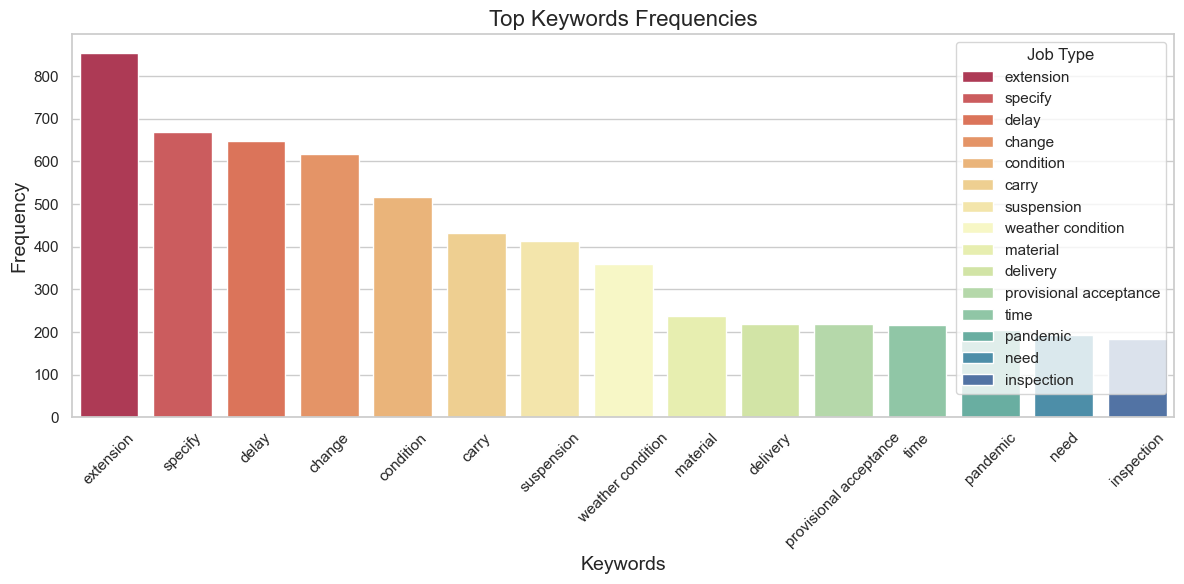

In [298]:
keyword_jus_sums = df1[filtered_keyword_list].sum().sort_values(ascending=False).reset_index()
keyword_jus_sums.columns = ['Keyword', 'Frequency']

keyword_jus_sums['Job Type'] = keyword_jus_sums['Keyword'].apply(lambda x: x.split('_')[0])

plt.figure(figsize=(12, 6))
sns.barplot(data=keyword_jus_sums, x='Keyword', y='Frequency', palette="Spectral", hue='Job Type', legend=True)

plt.title('Top Keywords Frequencies', fontsize=16)
plt.xlabel('Keywords', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [299]:
df1[(df1[filtered_keyword_list] == 0).all(axis=1)].shape[0]

1222

#### Justification for price change

In [300]:
df1['Justification for price change'].value_counts(dropna=False)

Justification for price change
NaN                                                                                                                                                                                                                                                                                       1554
underwork                                                                                                                                                                                                                                                                                  329
no change                                                                                                                                                                                                                                                                                  110
price review                                                                                                

In [301]:
1552/df1.shape[0]

0.31353535353535356

Here we have over 30% null values, so I would proceed to eliminate this feature directly as it may give us too little information and a TF-IDF approach would only result in an inconsistent feature increase.

In [302]:
df1.drop(columns=['Justification for price change', 'Justification for deadline change'], inplace=True)

With this last feature, I finished the column-by-column analysis of the data model.

## Final Data Model Analysis

I decide to delete the only Null record of ‘Classification of the multifactor criteria (%)’ as I would avoid imputing a value that could distort the initial distribution.

In [303]:
print(df1['Classification of the multifactor criteria (%)'].isna().sum())
df1.dropna(subset=['Classification of the multifactor criteria (%)'], inplace=True)
int_to_object = ['Closing Date Year', 'Closing Date Month', 'Signing Year', 'Signing Month', 'Award criteria class', 
                 'Publication Year', 'Close Year', 'E. price Class', 'Closing Date Day','Signing Day', 'I. price Class']
df1[int_to_object] = df1[int_to_object].astype('object')
df1.to_csv('PPPData_EN_cleaned.csv', index=False)

1


In [304]:
for col in df1.columns:
    print(df1[col].value_counts(dropna=False))
    print('\n')

Environmental criteria (T/F)
0    4678
1     271
Name: count, dtype: int64


Publication Year
2019    761
2020    716
2018    648
2017    632
2016    549
2014    382
2015    365
2013    302
2021    250
2012    139
2011    135
2010     61
2009      5
2022      4
Name: count, dtype: int64


Close Year
2021    956
2020    796
2015    689
2019    673
2022    637
2018    477
2016    407
2017    311
2014      2
2013      1
Name: count, dtype: int64


Municipality
Lisboa                  252
Porto                   138
Leiria                  135
Santa Maria da Feira    109
Amadora                 109
                       ... 
Idanha-a-Nova             1
Murça                     1
Mesão Frio                1
Arruda dos Vinhos         1
Monforte                  1
Name: count, Length: 277, dtype: int64


District
Lisboa                        702
Porto                         700
Aveiro                        484
Faro                          363
Braga                         359
Setúbal   

In [305]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4949 entries, 0 to 5115
Data columns (total 52 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Environmental criteria (T/F)                              4949 non-null   int32  
 1   Publication Year                                          4949 non-null   object 
 2   Close Year                                                4949 non-null   object 
 3   Municipality                                              4949 non-null   object 
 4   District                                                  4949 non-null   object 
 5   Submission deadline (days)                                4721 non-null   float64
 6   Diference between close and signing dates                 4949 non-null   object 
 7   Execution deadline (days)                                 4949 non-null   object 
 8   Base Bid Price (€)     

In [306]:
dtype_mapping = {
    'Closing Date Year': 'object',
    'Closing Date Month': 'object',
    'Signing Year': 'object',
    'Signing Month': 'object',
    'Award criteria class': 'object',
    'Publication Year': 'object',
    'Close Year': 'object',
    'E. price Class': 'object',
    'Closing Date Day': 'object',
    'Signing Day': 'object',
    'I. price Class': 'object'
}

df1 = pd.read_csv('PPPData_EN_cleaned.csv', dtype=dtype_mapping)

We retained 17 initial features, constructed 9 and added 25 features from the text. <br>
Before continuing with the analysis trying to find correlations, I finish sorting out the last remaining null values (in the Submission deadline (days) and Published in the EU journal columns), as now having processed all the features I can use KNN inputer solutions to impute the missing values.

Before applying the KNN Imputer, I make sure to scale the numerical features to maximise performance.

As a scaling technique, I choose the **Min-Max Scaler** because we know the maximum and minimum values for the features and these do not dominate the distributions, preventing the data from becoming unbalanced.

I do not use **standardisation** because the variables do not follow a Gaussian distribution. Consequently, using a standardisation strategy would excessively alter the original distribution of the data. In this context, I simply prefer to preserve it by rescaling the interval between 0 and 1.

In [307]:
# Select the numerical columns
numerical_cols = df1[['Initial price (€)',
 'Effective Price (€)',
 'Difference between the effective and initial price (€)',
 'Proportion between the effective and initial price (%)',
 'Classification of the multifactor criteria (%)',
 'Number of bidders',
 'Base Bid Price (€)_old']].columns.to_list()

df1 = scale(df1, scaler='minmax', columns=numerical_cols, scaler_filename='minmax_scaler.joblib', scaler_filename_prop='minmax_scaler_prop.joblib')

In order to use the **KNN Imputer** optimally, I avoid converting and selecting all categorical features into numerical ones, as having too many features could distort the calculation of distance between neighbours.

Therefore, I only perform **one-hot encoding** for selected categorical variables that do not introduce too many values. In this way, I reduce the negative impact on the calculation of distances and improve the effectiveness of the algorithm.

So starting from the feature Submission deadline (days), I see the **correlation matrix** with all the converted variables (for the categorical ones I apply the one-hot on a copy of the dataset) and select only those that have an absolute correlation greater than 0.3, in this way I select only those features and pass them to the KNNInputer.

In [308]:
categorical_cols = df1.select_dtypes(include='object').columns.to_list()
df1_encoded = pd.get_dummies(df1, columns=categorical_cols)

Here I calculate the correlation matrix and select the features with a positive or negative correlation of 0.3 upwards

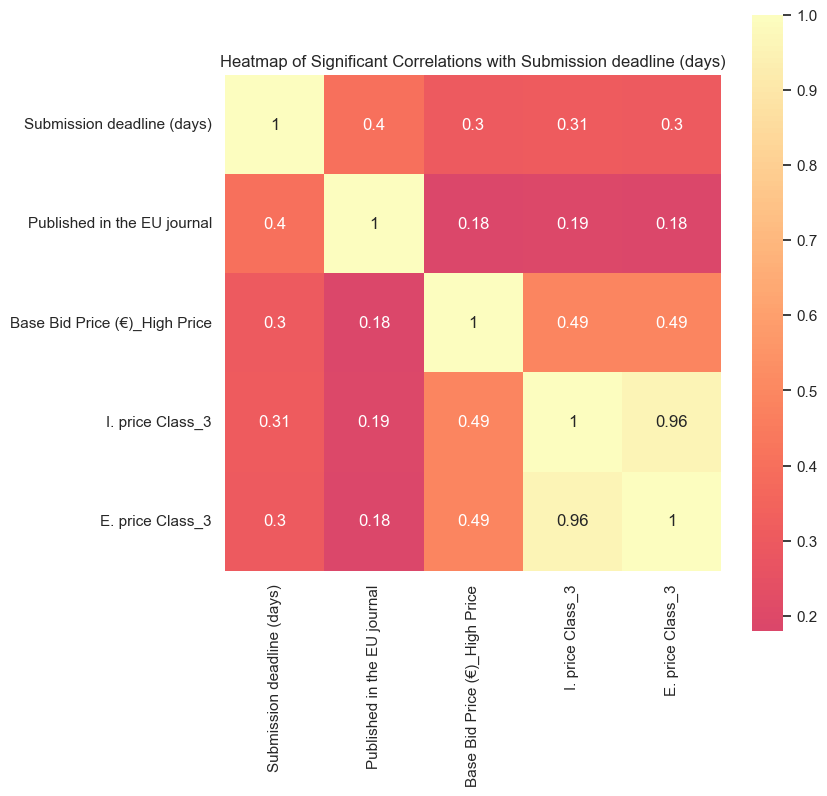

In [309]:
cols_of_interest = plot_significant_correlations_heatmap(df1_encoded, 'Submission deadline (days)', threshold=0.3)

I use weights=‘uniform’ because all neighbours have the same weight, I don't care to prioritise some neighbours, especially as there are some values a bit out of scale from the features.

**Optimal Choice for n_neighbors in KNNImputer**

After analyzing the impact of different `n_neighbors` values on the imputation of the **"Submission deadline (days)"** column, the following observations were made:

- **Optimal Value**: **5**
  
**Reasons:**

1. **Minimum Mean Value**: The mean value of the imputed submission deadline was lower when `n_neighbors` was set to 5, indicating a more conservative and potentially more accurate estimate.

2. **Stability**: The graph shows that as neighbors increase from 1 to 5, the mean value tends to decrease, suggesting that the influence of closer neighbors is more representative for this column.

3. **Increase Beyond 5**: Starting from 5 neighbors, an increase in the mean value was noted, indicating that including more distant neighbors might introduce noise into the data, reducing the accuracy of the imputation.

**Conclusion**

Therefore, the value of `n_neighbors` of **5** is considered the best for imputing the **"Submission deadline (days)"** column in the context of our dataset, as it offers an optimal trade-off between accuracy and stability.

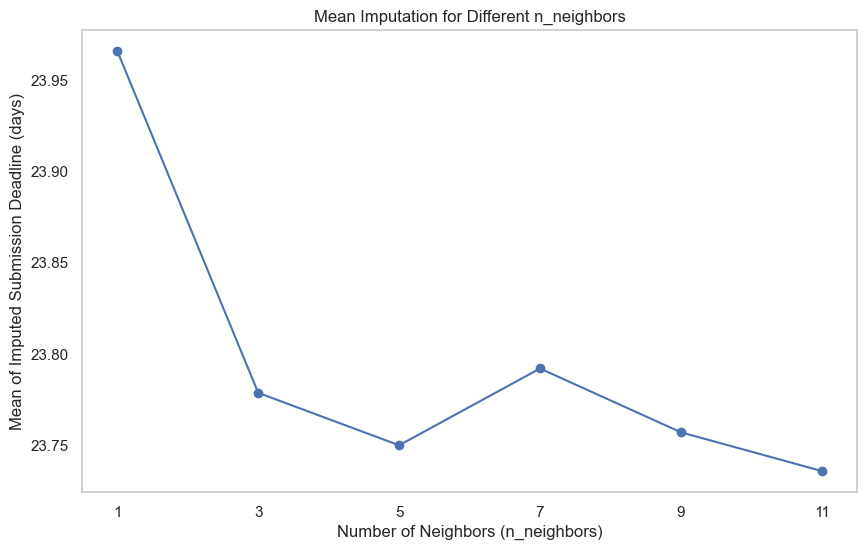

In [310]:
evaluate_knn_imputation(df1_encoded, 'Submission deadline (days)', cols_of_interest, neighbors_list=[1, 3, 5, 7, 9, 11])

In [311]:
cols_of_interest

['Submission deadline (days)',
 'Published in the EU journal',
 'Base Bid Price (€)_High Price',
 'I. price Class_3',
 'E. price Class_3']

In [312]:
# Inpute missing values using KNN imputation
df_imputed = knn_impute_data(df1_encoded, cols_of_interest, 'Submission deadline (days)', n_neighbors=3)

# Check the imputed data
df1['Submission deadline (days)'] = df_imputed['Submission deadline (days)']
df1['Submission deadline (days)'].value_counts()

Submission deadline (days)
30.0     802
20.0     684
15.0     479
21.0     439
14.0     400
        ... 
65.0       1
100.0      1
73.0       1
76.0       1
97.0       1
Name: count, Length: 78, dtype: int64

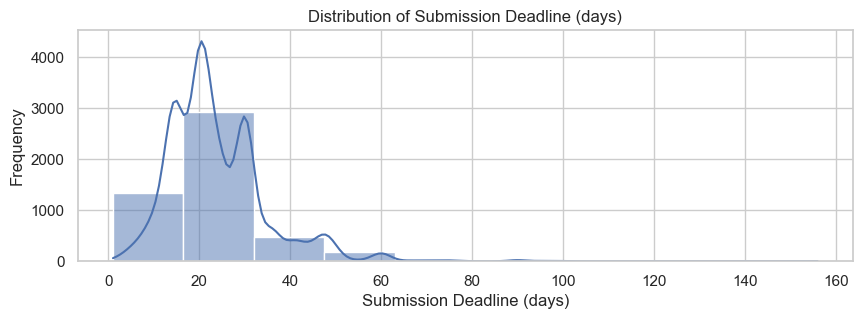

In [313]:
# Plot the distribution of Submission deadline (days)
plt.figure(figsize=(10, 3))
sns.histplot(df1['Submission deadline (days)'].dropna(), bins=10, kde=True)
plt.title('Distribution of Submission Deadline (days)')
plt.xlabel('Submission Deadline (days)')
plt.ylabel('Frequency')
plt.show()

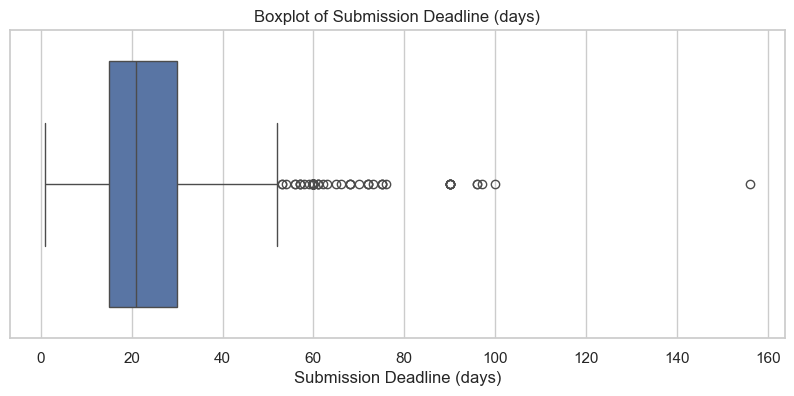

In [314]:
# Plot the boxplot for Submission deadline (days)
plt.figure(figsize=(10, 4))
sns.boxplot(x=df1['Submission deadline (days)'])
plt.title('Boxplot of Submission Deadline (days)')
plt.xlabel('Submission Deadline (days)')
plt.show()

1. Most of the data is concentrated in the first 30 days, with a skewed distribution and a significant presence of outliers beyond 50 days.
2. Given the number of outliers, the distribution is rather scattered, with a long tail. This further confirms that equal depth binning might be preferable to better split the data, as most observations are concentrated in the first few days, while outliers are distributed much further apart.
3. I also use a previously defined function that detects and categorises outliers using interquartile distance and thresholds, in practice I classify outliers into small, medium and extreme using thresholds (1x, 2x and above) so as not to completely eliminate all outliers but to remove the most problematic ones in order to preserve the amount of data and the distribution.
In this case I remove the extreme outliers while preserving the natural distribution of the feature.

In [315]:
# Find and categorize outliers
df1 = df1.reset_index(drop=True)
result_dataset = detect_and_categorize_outliers(df1, 'Submission deadline (days)')['outlier_category']
idx = result_dataset[(result_dataset == 'extreme outlier above') | (result_dataset == 'extreme outlier below')].index
print(f"Number of average and extreme outliers: {len(idx)}")
df1 = df1.drop(index=idx)
df1, bins = discretize(df1, 'Submission deadline (days)', n_bins=5, strategy='quantile', print_bins=True)

Number of average and extreme outliers: 12


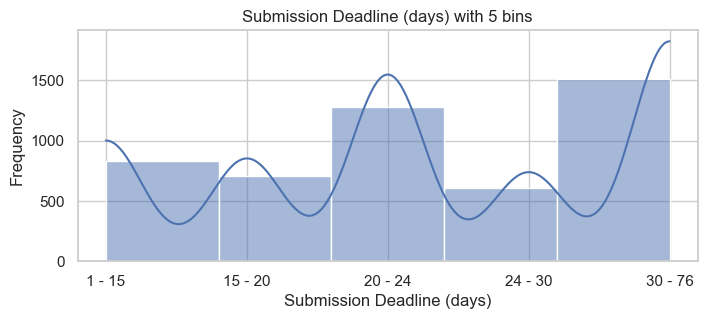

In [316]:
plt.figure(figsize=(8, 3))
sns.histplot(df1['Submission deadline (days)'], bins=5, kde=True)
plt.xticks(ticks=np.arange(5), labels=[f"{int(bins[i])} - {int(bins[i+1])}" for i in range(len(bins) - 1)])
plt.title('Submission Deadline (days) with 5 bins')
plt.xlabel('Submission Deadline (days)')
plt.ylabel('Frequency')
plt.show()

In [317]:
df1['Submission deadline (days)'] = df1['Submission deadline (days)'].replace({0.0: 'Very Short', 1.0: 'Short', 2.0: 'Medium', 3.0: 'Long', 4.0: 'Very Long'})

With 5 intervals you distribute the variables well

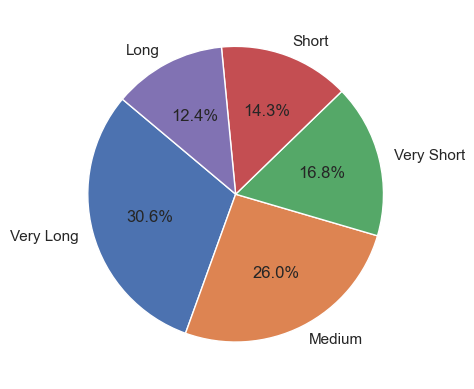

In [318]:
plt.pie(df1['Submission deadline (days)'].value_counts(), labels=df1['Submission deadline (days)'].value_counts().index, autopct='%1.1f%%', startangle=140);

I now apply the same procedure for Published in the EU journal

In [319]:
df1['Published in the EU journal'].value_counts(dropna=False)

Published in the EU journal
0.0    3461
NaN    1352
1.0     124
Name: count, dtype: int64

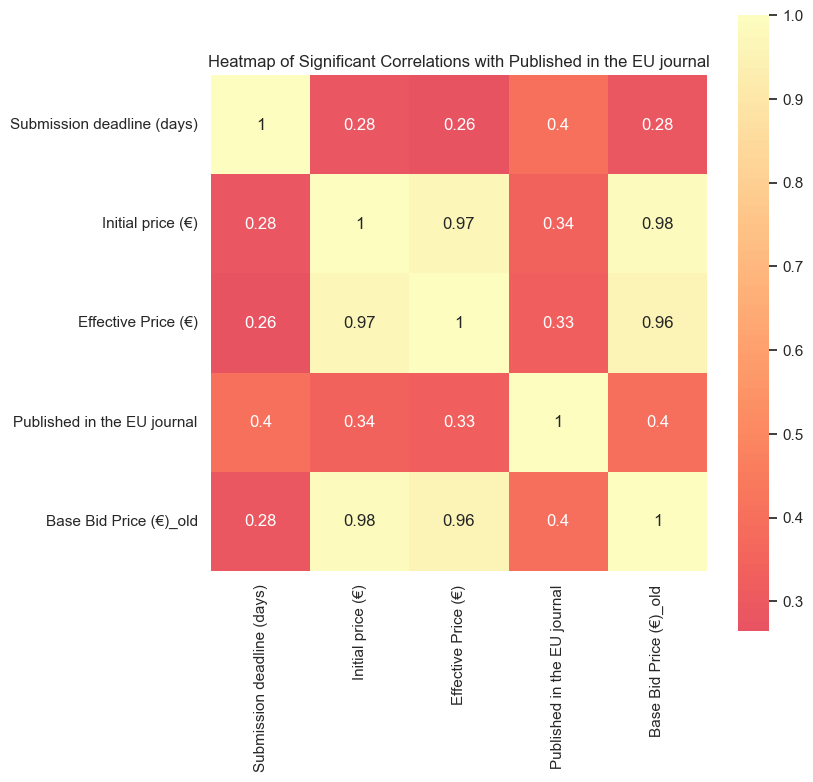

In [320]:
cols_of_interest = plot_significant_correlations_heatmap(df1_encoded, 'Published in the EU journal', threshold=0.3)

Here I choose 3 as the neighbour, so as not to smooth and flatten the dataset feature too much. In fact, as I go down to 9 I have more stability (the line flattens out, but at the same time I condition my data a lot, as I have so many values at False here, too many neighbours could make me underestimate the class to False by a lot).

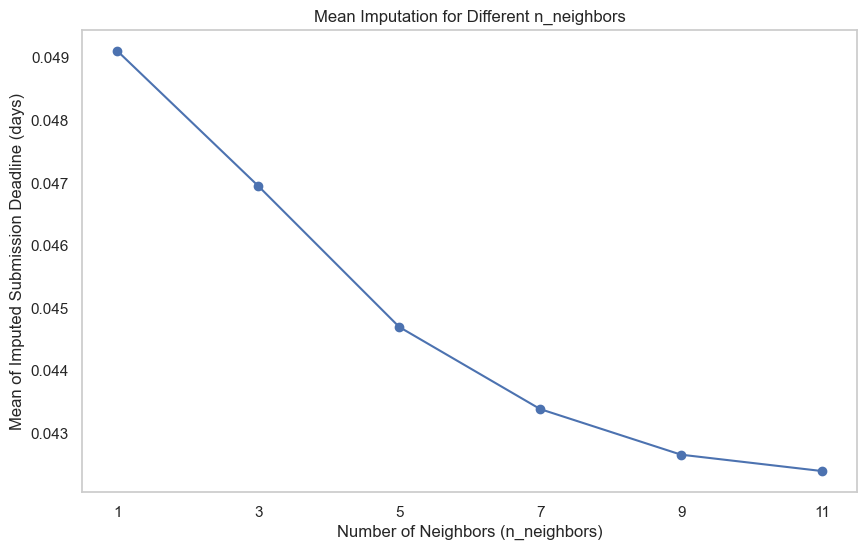

In [321]:
evaluate_knn_imputation(df1_encoded, 'Published in the EU journal', cols_of_interest, neighbors_list=[1, 3, 5, 7, 9, 11])

In [322]:
# Inpute missing values using KNN imputation
df_imputed = knn_impute_data(df1_encoded, cols_of_interest, 'Published in the EU journal', n_neighbors=3)

# Check the imputed data
df1['Published in the EU journal'] = df_imputed['Published in the EU journal'].round().astype(bool)
df1.drop(['outlier_category'], axis=1, inplace=True)
df1['Published in the EU journal'].value_counts()

Published in the EU journal
False    4751
True      186
Name: count, dtype: int64

It is also in line with the proportions, initially the True values were 3% false, we had about 1480 values at NaN, so 44 new True values were added to the 131. So I evened out the proportion too.

I show the finished datamodel: 53 features including processed text and 4937 lines, losing about 277 records, i.e. about 5%. <br> I would say a more than acceptable loss.

In [323]:
original_shape

(5214, 38)

In [324]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4937 entries, 0 to 4948
Data columns (total 52 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Environmental criteria (T/F)                              4937 non-null   int64  
 1   Publication Year                                          4937 non-null   object 
 2   Close Year                                                4937 non-null   object 
 3   Municipality                                              4937 non-null   object 
 4   District                                                  4937 non-null   object 
 5   Submission deadline (days)                                4937 non-null   object 
 6   Diference between close and signing dates                 4937 non-null   object 
 7   Execution deadline (days)                                 4937 non-null   object 
 8   Base Bid Price (€)     

In [325]:
df1.to_csv('PPPData_EN_cleaned_imputed.csv', index=False)

# Feature Selection

Before proceeding with the clustering algorithm, it is important to perform **feature selection** to reduce the complexity of the model and achieve better results. Having too many variables can lead to issues such as the **curse of dimensionality**. Specifically, too many attributes can cause:

- **Difficulty in finding significant patterns**: The data becomes more distant and harder to cluster.
- **Redundant features**: Some variables may be correlated, providing similar information and increasing noise in the model.
- **Risk of overfitting**: A high number of features can lead the model to fit too closely to the data, reducing its ability to generalize.

To avoid these problems, I want to select only the most relevant variables. There are various techniques for performing feature selection, which can be mainly divided into **filter methods** and **wrapper methods**. Since I do not have a defined target class, and **wrapper methods** are computationally more intensive, I will avoid the latter and focus on **filter methods**.

### Filter Methods

**Filter methods** do not require a target variable and rely on statistical criteria, such as distance metrics or information measures, to evaluate the importance of each feature.

#### 1. **PCA (Principal Component Analysis)**

**PCA** is a dimensionality reduction technique that transforms the original variables into new **principal components**, which are linear combinations of the existing features. This method allows for reducing the dimensionality of the dataset while retaining only the components that explain most of the variance.

- **Pros**: Effectively reduces dimensionality and simplifies the dataset.
- **Cons**: The resulting components are not directly interpretable as the original features.

Although PCA is effective for reducing dimensions, I would avoid it in this case because I need to maintain the interpretability of the variables, as I will later perform an analysis on **association rules**.

#### 2. **Variance Threshold & Entropy-Based Selection**

**Variance threshold selection** is a method that eliminates numerical variables that have very low variance. If a feature does not vary much, it provides little useful information for clustering and can be discarded.

- **Pros**: A simple and quick method for removing the least relevant features.
- **Cons**: May not capture complex relationships between variables.

This is an approach I will initially try to eliminate irrelevant features, that is, those that do not contribute significantly to the overall variability of the dataset.

For categorical variables, I will use entropy, relative to the number of classes, to eliminate less informative variables.

#### 3. **Using Models**

I can also use supervised learning models, such as **Random Forest**, to assess the importance of the features. Although these models are usually used in supervised contexts, they can still be useful for identifying the most relevant variables even in an unsupervised clustering task.

- **Pros**: Maintains the integrity of the original variables and automatically identifies the most relevant ones.
- **Cons**: Requires defining a simulated target variable (e.g., binary), which adds an additional task.

I will try this approach at the end, as it is effective but introduces a new phase that could complicate the analysis. It will serve as a final check to verify whether the selected variables are indeed relevant.

In [326]:
df1.head()

Environmental criteria (T/F) Publication Year Close Year Municipality  \
0                             0             2020       2022       Almada   
1                             0             2020       2022        Viseu   
2                             0             2022       2022        Loulé   
3                             0             2020       2022        Viseu   
4                             0             2021       2022        Viseu   

  District Submission deadline (days)  \
0  Setúbal                  Very Long   
1    Viseu                       Long   
2     Faro                       Long   
3    Viseu                      Short   
4    Viseu                      Short   

  Diference between close and signing dates Execution deadline (days)  \
0                               Medium Days             Long Deadline   
1                               Medium Days            Short Deadline   
2                                  Few Days            Short Deadline   
3                               Medium Days            Short Deadline   
4                                  Few Days            Short Deadline   

  Base Bid Price (€)  Initial price (€)  ... extension  inspection  material  \
0          Low Price           0.002008  ...         0           0         0   
1          Low Price           0.000456  ...         0           0         0   
2          Low Price           0.000189  ...         0           0         0   
3          Low Price           0.000450  ...         1           0         0   
4          Low Price           0.000436  ...         0           0         0   

   need pandemic  provisional acceptance  specify  suspension time  \
0     0        0                       0        0           0    0   
1     0        0                       0        1           0    0   
2     0        0                       0        0           0    0   
3     0        0                       0        0           0    1   
4     0        0                       0        0           0    0   

  weather condition  
0                 0  
1                 0  
2                 0  
3                 1  
4                 0  

[5 rows x 52 columns]

First of all I identify those features that are redundant, to do this I use a correlation matrix to see if they are too correlated of features (0.8, 0.9), see their semantic meaning, and there evaluate whether to eliminate them because they may have the same information.

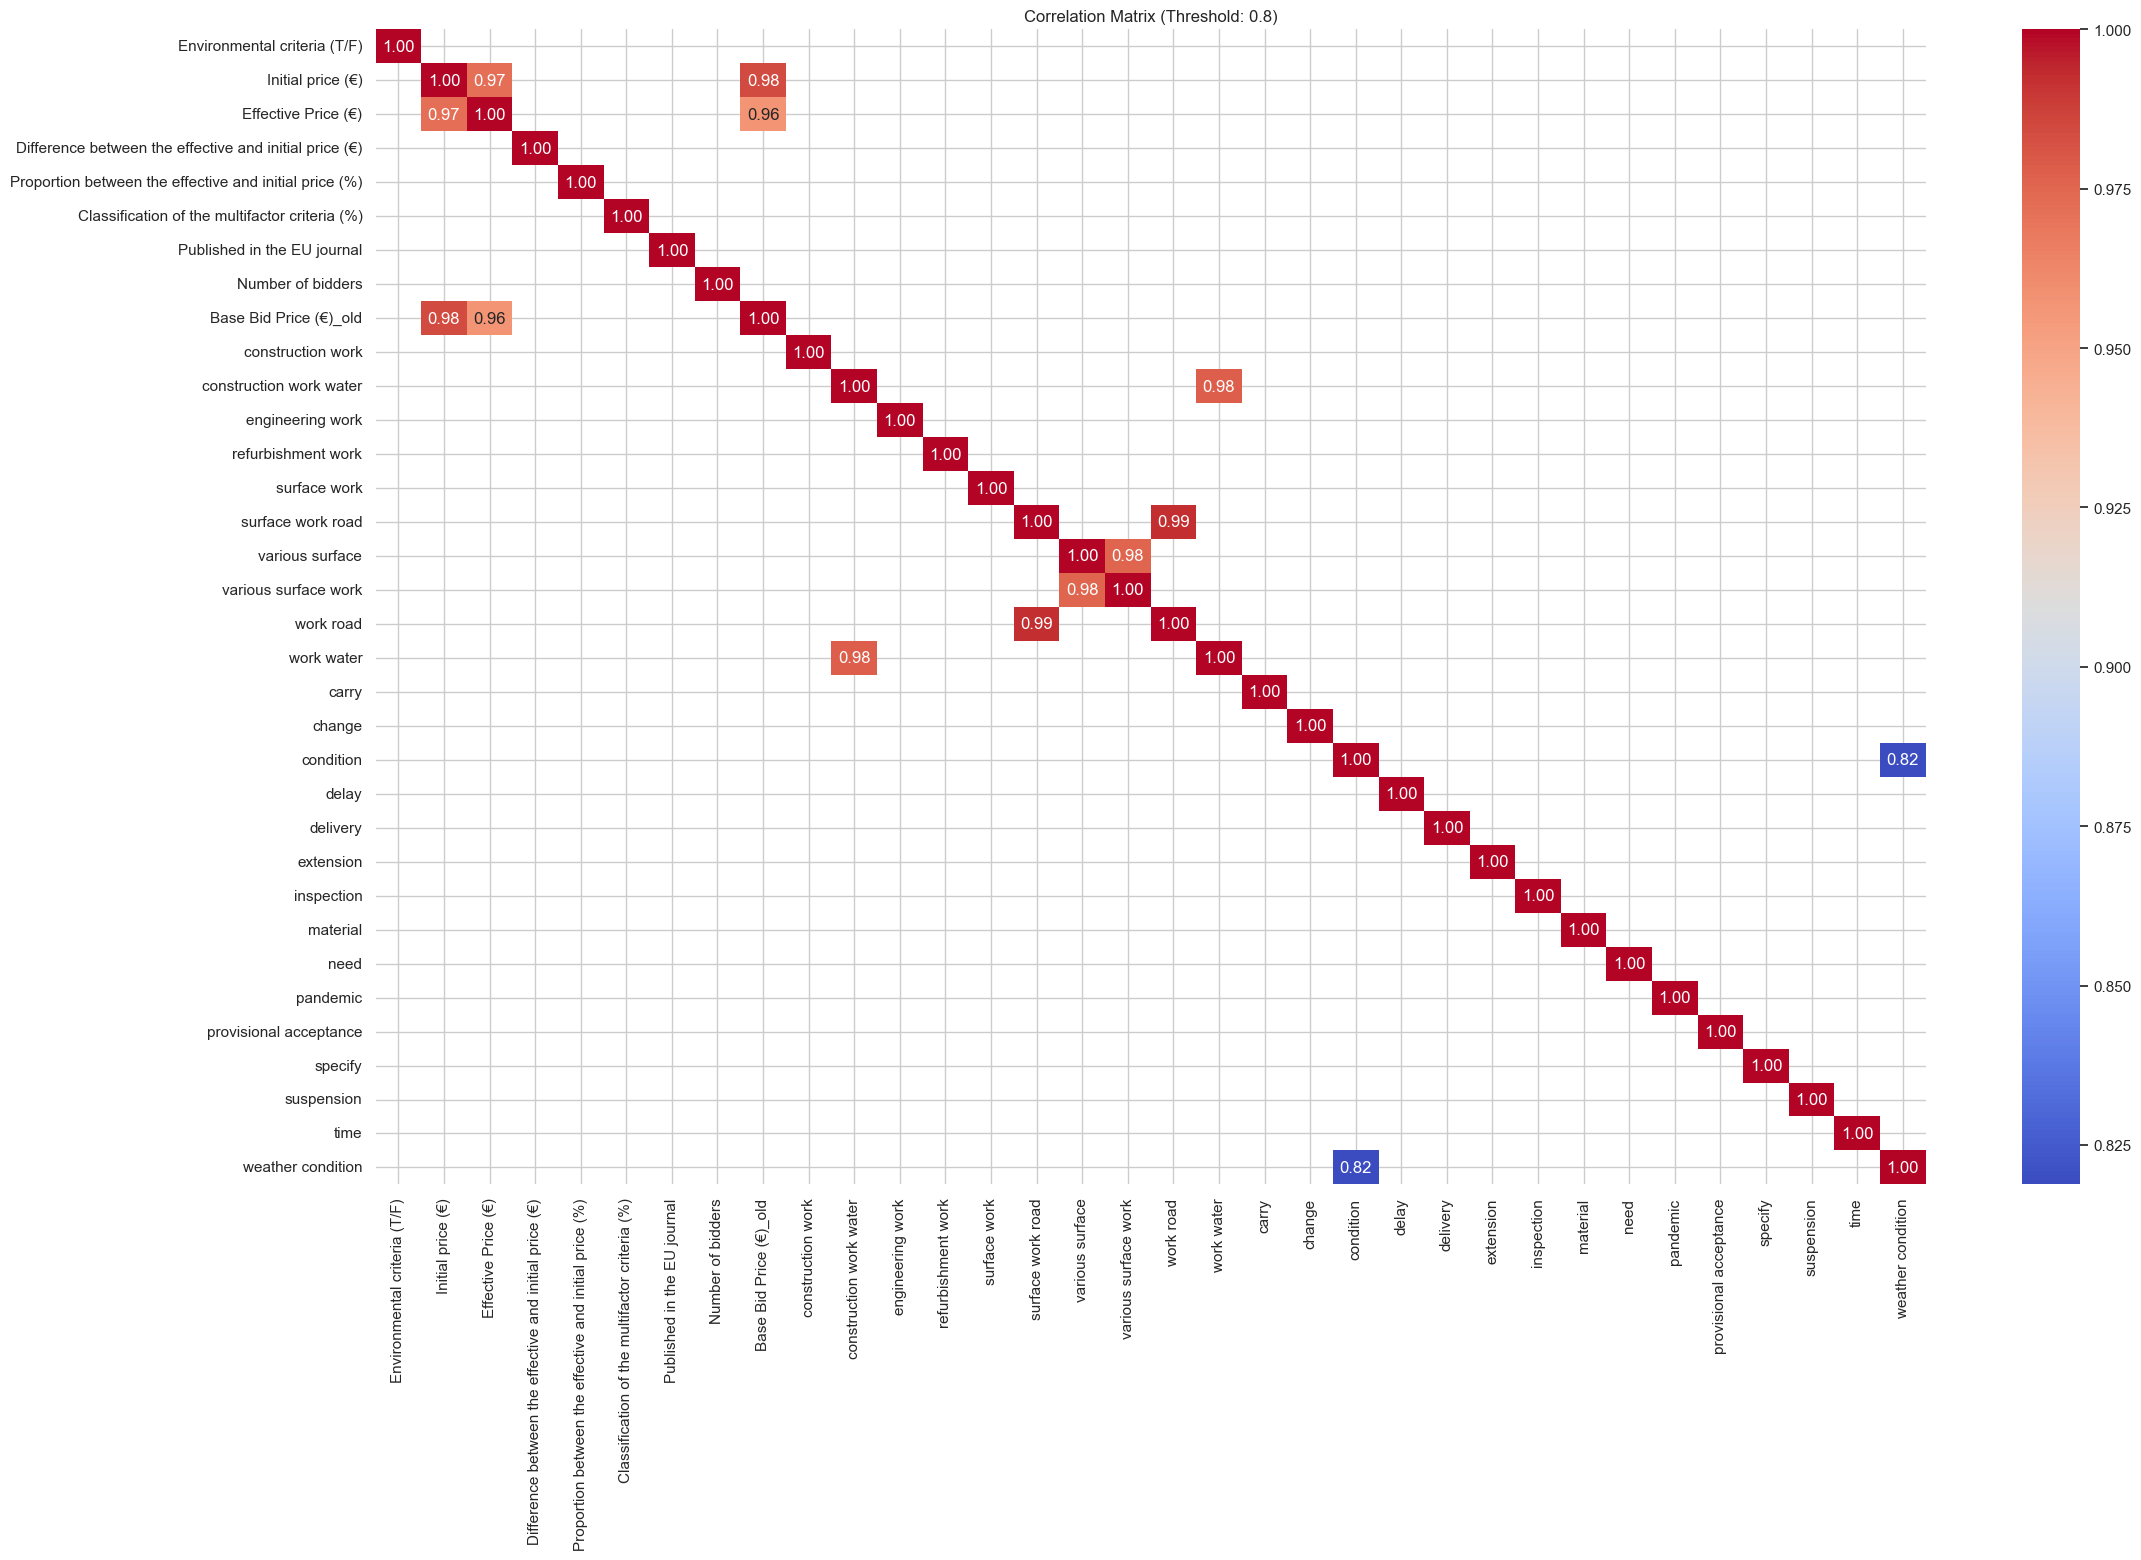

In [327]:
plot_high_correlation_matrix(df1, threshold=0.8, figsize=(25, 15))

Here some features can also be dropped on the basis of semantics, base bid price, effective price and initial price I prefer to keep them like this.

In [328]:
df1.drop(columns=['work water', 'work road', 'various surface', 'condition'], inplace=True)

Controlling Outliers

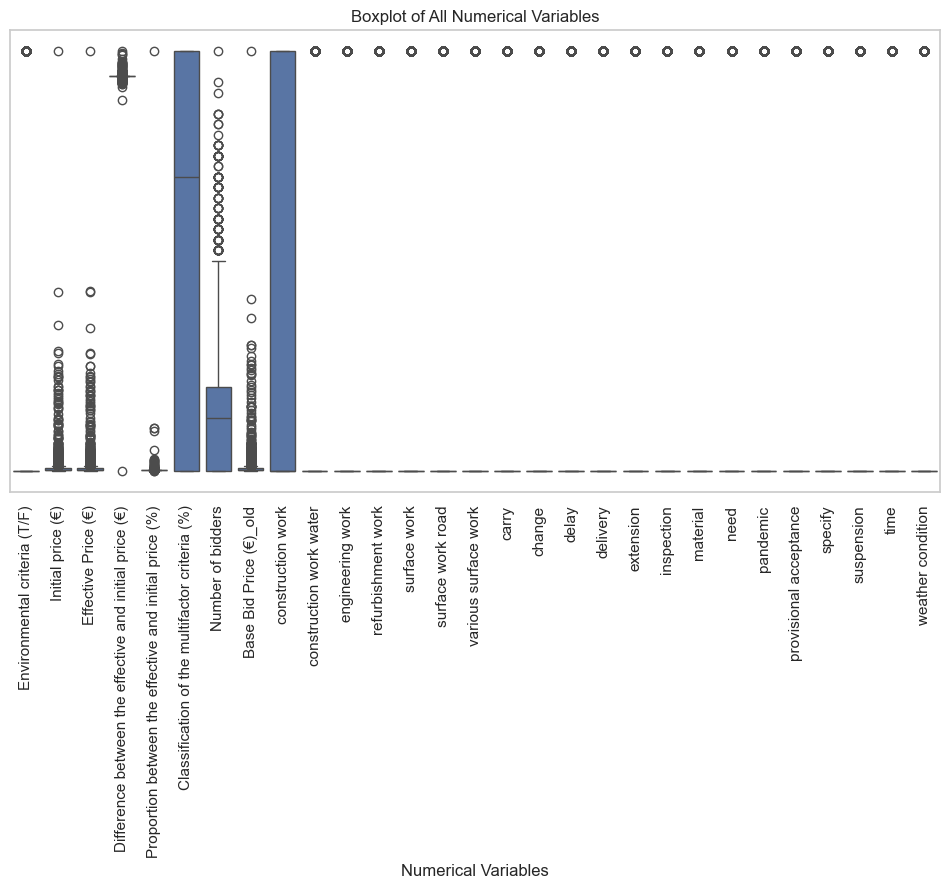

In [329]:
numerical_vars = df1.select_dtypes(include=['number']).columns.tolist()

df_long_numerical = pd.melt(df1, value_vars=numerical_vars, var_name='Variable', value_name='Value')

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_long_numerical, x='Variable', y='Value')
plt.title('Boxplot of All Numerical Variables')
plt.xlabel('Numerical Variables')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.gca().axes.get_yaxis().set_visible(False)
plt.show()

There are quite a few for these variables, which suggests to me to try using price classes rather than the price itself.

I will check for outliers in the categorical variables.

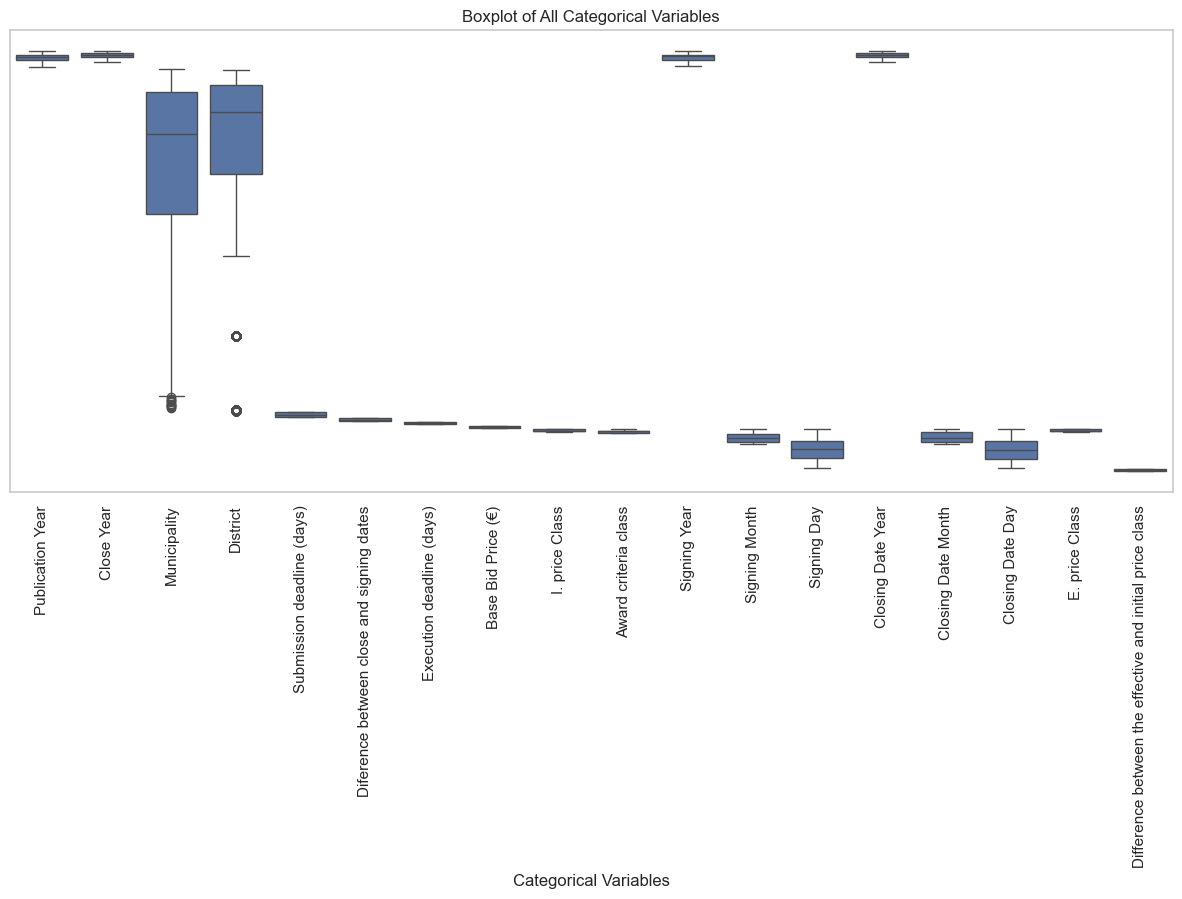

In [330]:
categorical_vars = df1.select_dtypes(include=['object', 'category']).columns.tolist()

df_long = pd.melt(df1, value_vars=categorical_vars, var_name='Variable', value_name='Value')
plt.figure(figsize=(15, 6))
sns.boxplot(data=df_long, x='Variable', y='Value')
plt.title('Boxplot of All Categorical Variables')
plt.xlabel('Categorical Variables')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.gca().axes.get_yaxis().set_visible(False)
plt.show()

Except for Municipality and District I see no outliers to report, and for the price classes this confirms what I observed earlier.

For the categorical variables, I will use the Chi-Squared test to examine the number of occurrences and see if there are any variables that can be dropped.

> **Note**: I use the Chi-Squared test to identify only **strong correlations** between categorical variables. It is essential that these correlations are also validated from a **semantic** and **contextual** standpoint. A significant p-value indicates only that the variables are not independent; it does not provide information about the direction or importance of the relationship. Therefore, the results must be interpreted with caution and considered within the context of the application domain.

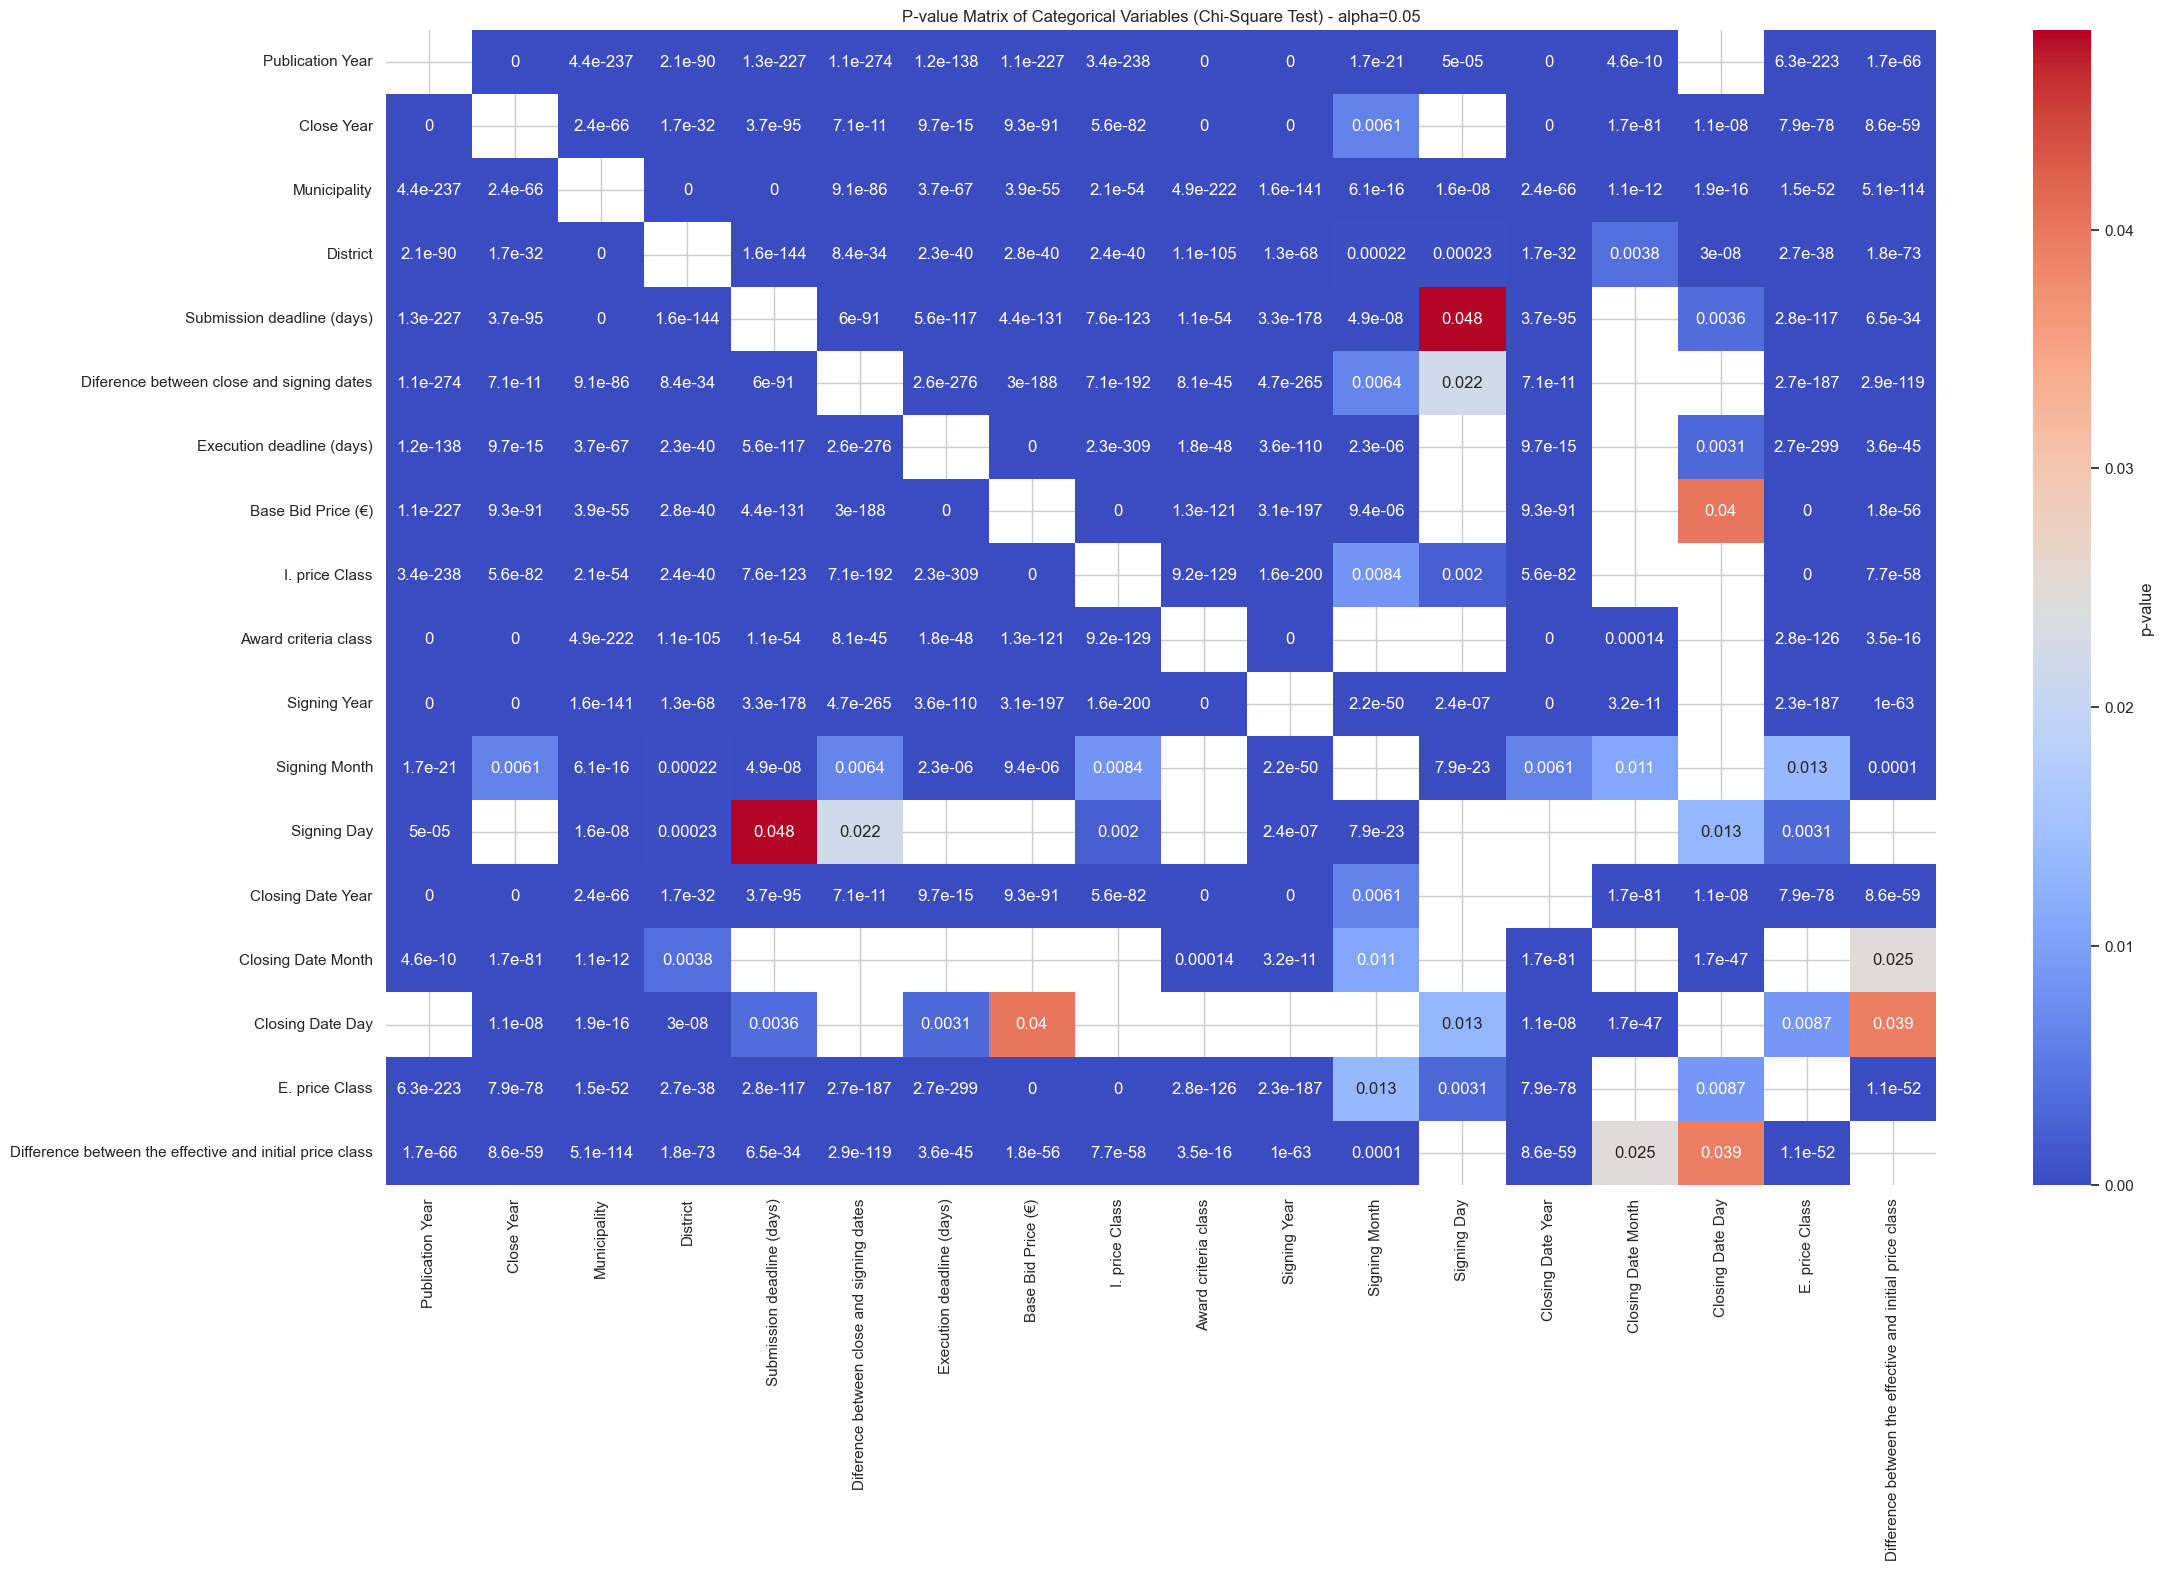

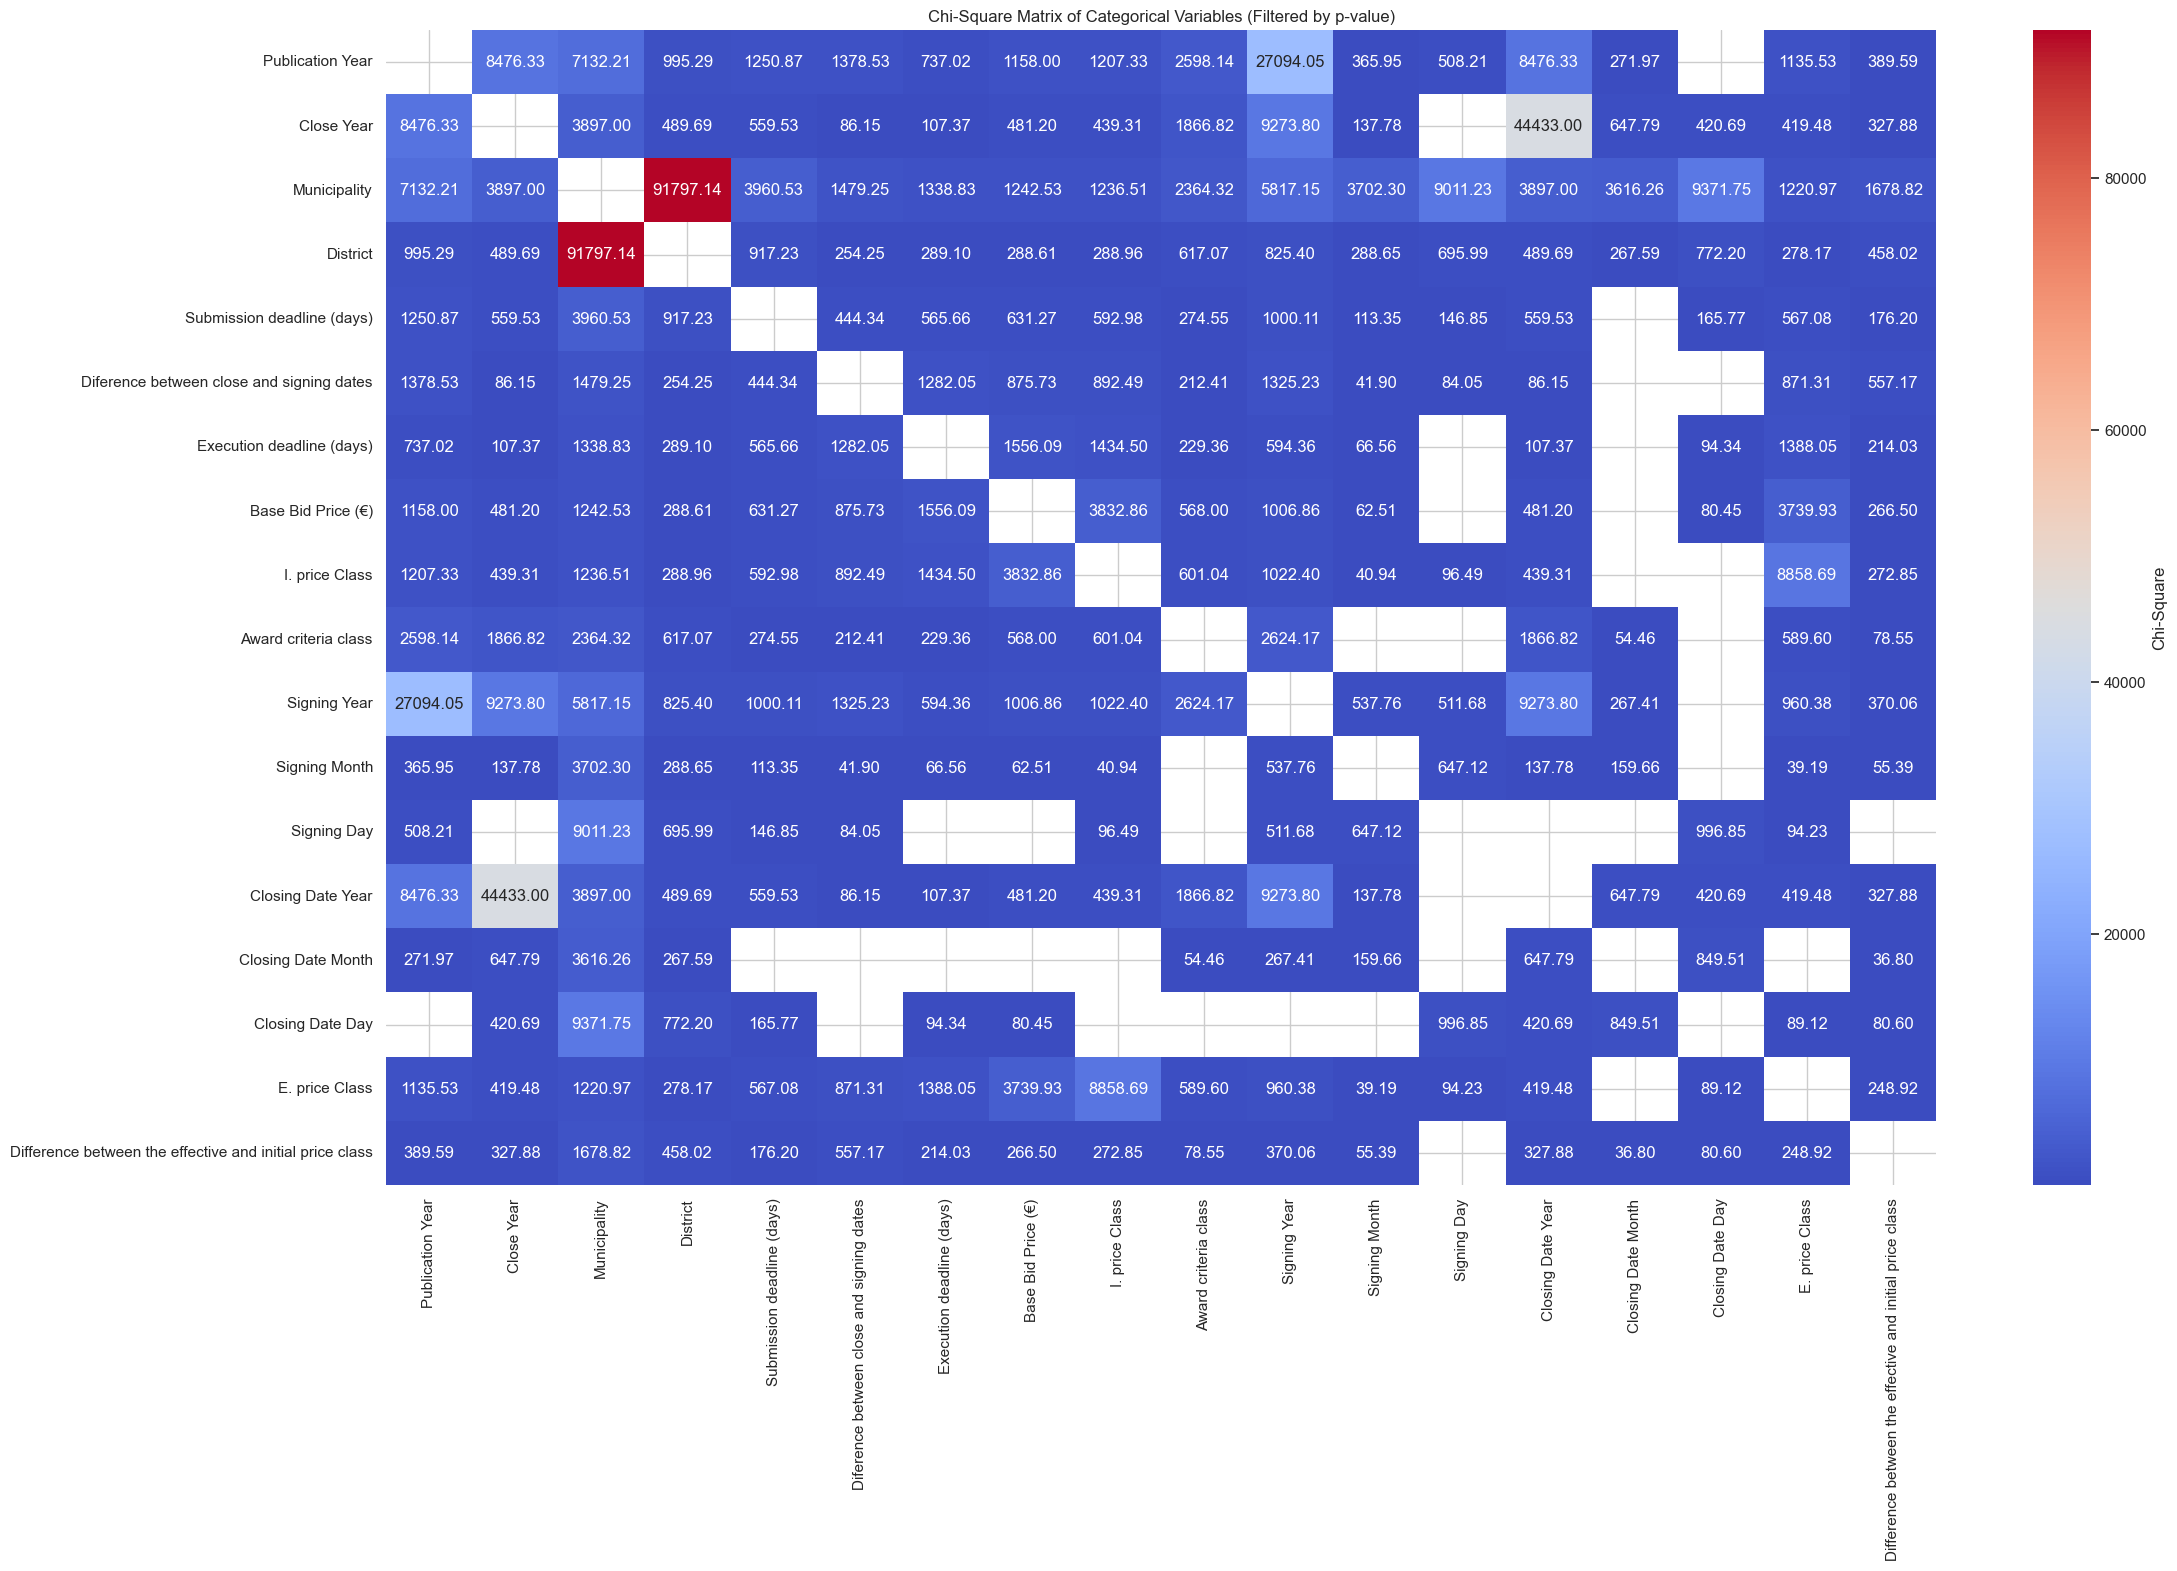

In [331]:
p_value, chi_square = chi_square_and_pvalue_matrices(df1, figsize=(25,15))

I don't see any redundant variables from this schema, perhaps only District and Municipality, but for now, I want to keep both variables.

I will proceed with variance analysis to eliminate non-discriminative features, applying a very low threshold to avoid removing too many features. However, before choosing the variance, I will first examine the distribution:

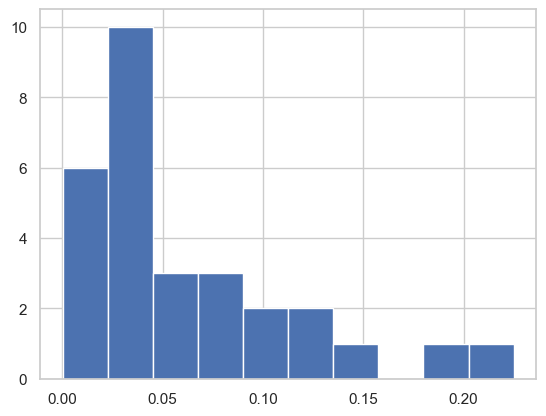

In [332]:
df_numeric = df1.select_dtypes(include=['number'])
varianze = df_numeric.var()
varianze.hist();

In light of this, I would avoid setting a threshold that is too high, and I believe that the right compromise is 0.02, so as to retain several features and test whether the remaining ones have a significant impact.

### Feature Selection

In [333]:
remaining_columns = select_features_variance(df1, threshold=0.02).columns
columns_cancelled = df_numeric[df_numeric.columns.difference(remaining_columns)].columns.to_list()
columns_cancelled

['Base Bid Price (€)_old',
 'Difference between the effective and initial price (€)',
 'Effective Price (€)',
 'Initial price (€)',
 'Proportion between the effective and initial price (%)']

The columns that have been excluded mainly concern prices, and since I have the equivalent discretized categorical features, I would eliminate these features. If I encounter poor results with clustering, I could consider reintroducing them. 

The only doubt is regarding the column that relates to the proportion since I do not have the categorical equivalent; therefore, before eliminating it, I will try to plot some scatterplots.

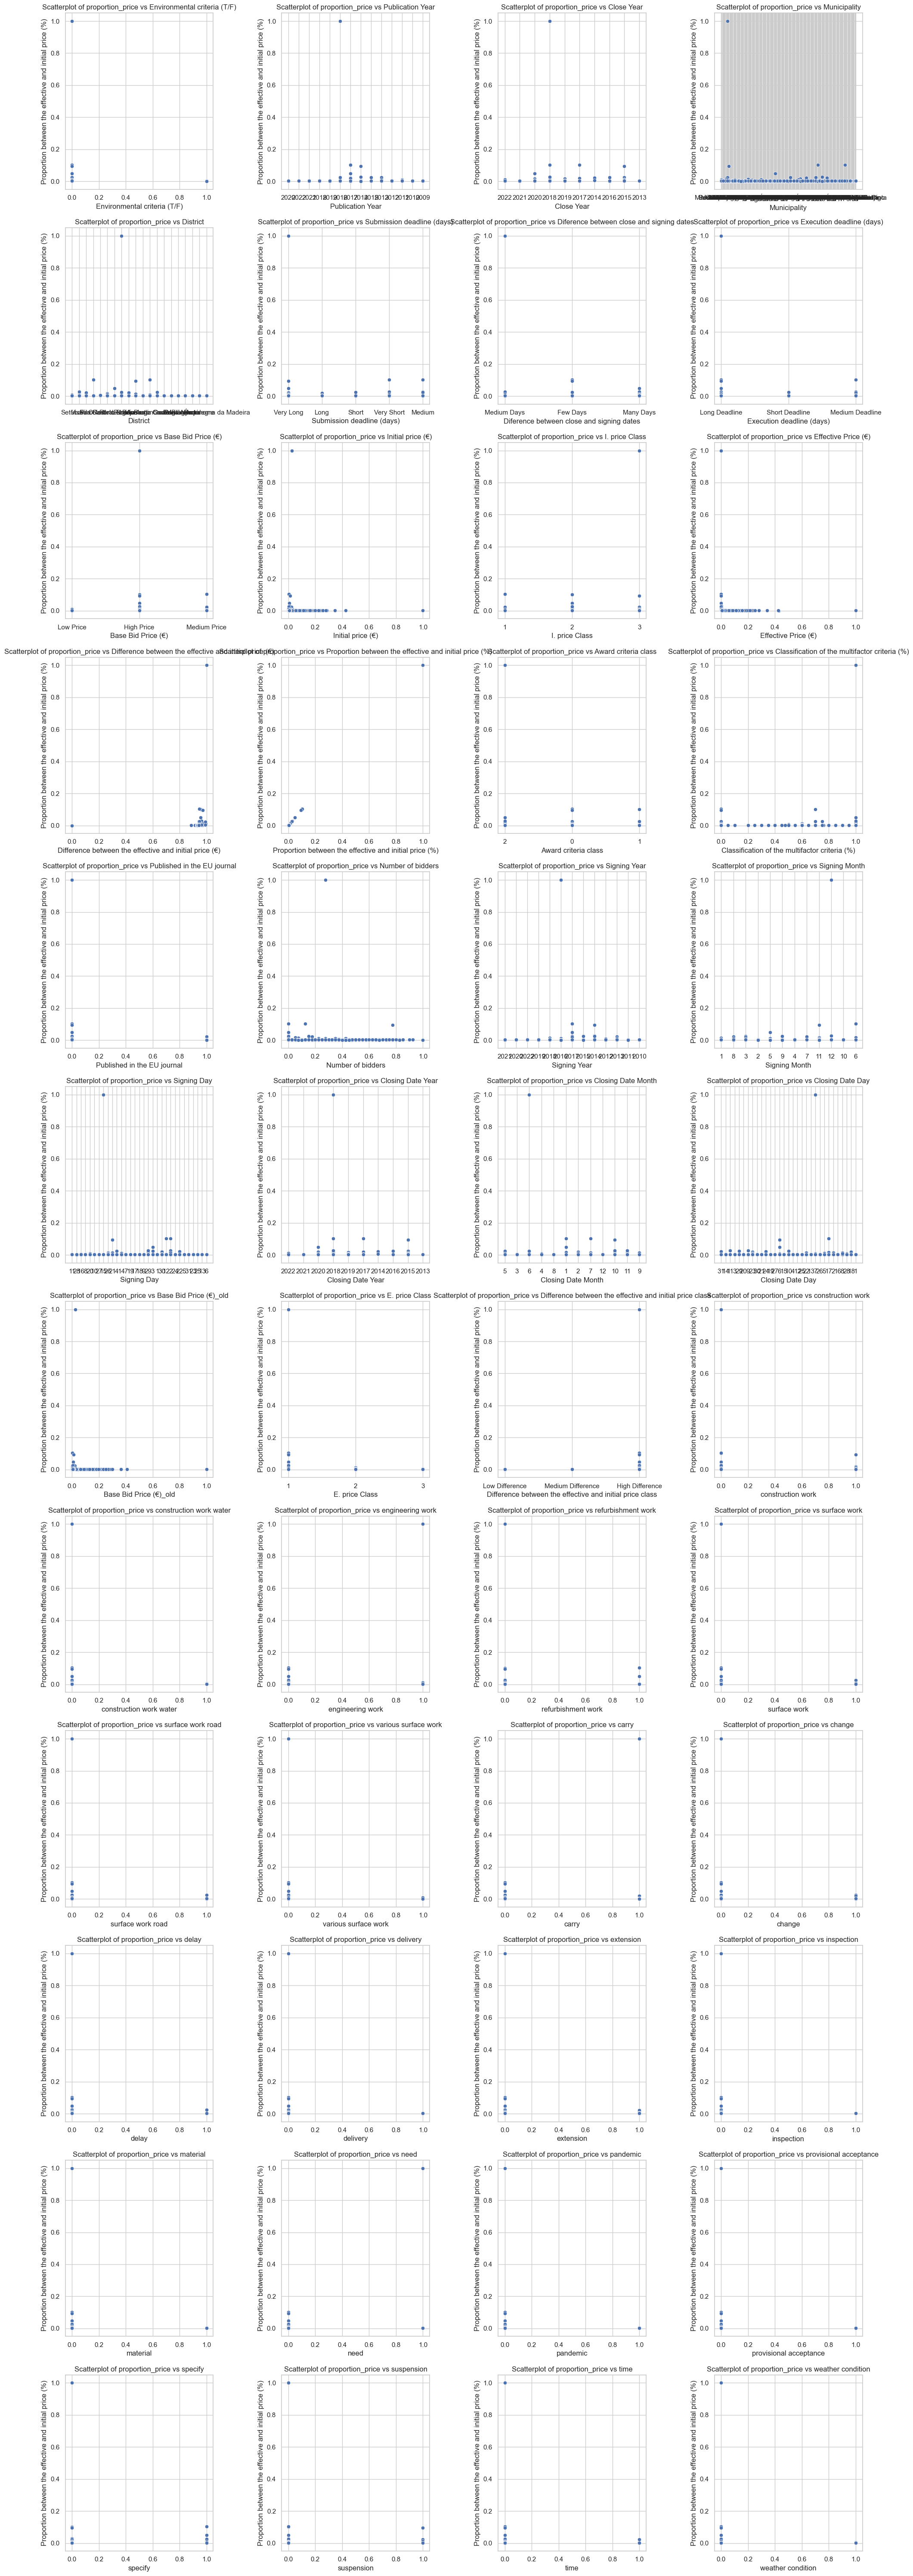

In [334]:
n_cols = 4
n_rows = math.ceil(len(df1.columns) / n_cols)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 5))

axs = axs.ravel()

for i, col in enumerate(df1.columns):
    sns.scatterplot(x=df1[col], y=df1['Proportion between the effective and initial price (%)'], ax=axs[i])
    axs[i].set_title(f'Scatterplot of proportion_price vs {col}')
    axs[i].set_xlabel(col)
    axs[i].set_ylabel('Proportion between the effective and initial price (%)')

for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

In general, I do not see a strong correlation with the other variables; therefore, it can be deleted.

In [335]:
df1.drop(columns=columns_cancelled, inplace=True)

Now, for the categorical features, I would like to find a method to select only those that truly provide information. To do this, I will use entropy. Clearly, the absolute value of entropy does not tell us much; it must be related to the reference class in order to accurately select the features of interest. 

Therefore, I decide to normalize the entropy based on the number of classes:

$$H_n(X) = \frac{H(X)}{\log_2(n)}$$

where:
1. \(H(X)\) is the calculated entropy.
2. \(n\) is the number of distinct categories.

Thus, a value of 0 indicates minimum entropy, meaning it provides no information as all instances fall into one class, while a value of 1 indicates maximum entropy.

C:\Users\dommy\AppData\Local\Temp\ipykernel_13992\369806465.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=entropy_results.index, y='Normalized Entropy', data=entropy_results, palette='viridis')
C:\Users\dommy\AppData\Local\Temp\ipykernel_13992\369806465.py:13: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


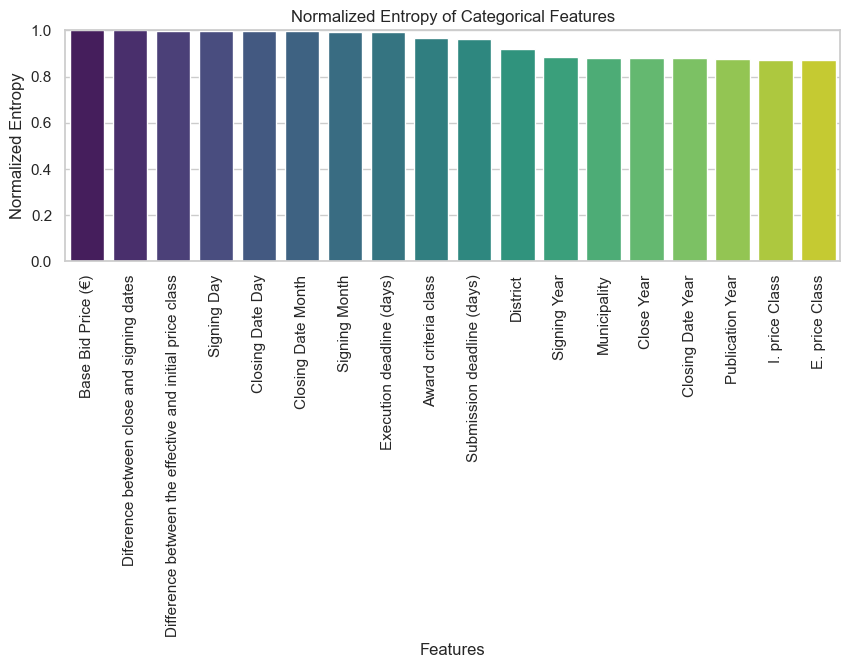

In [336]:
normalized_entropies = {col: calculate_entropy_normalized(df1[col]) for col in df1.select_dtypes(include=['object', 'category']).columns}

entropy_results = pd.DataFrame.from_dict(normalized_entropies, orient='index', columns=['Normalized Entropy'])
entropy_results = entropy_results.sort_values(by='Normalized Entropy', ascending=False)

plt.figure(figsize=(10, 3))
sns.barplot(x=entropy_results.index, y='Normalized Entropy', data=entropy_results, palette='viridis')
plt.title('Normalized Entropy of Categorical Features')
plt.xlabel('Features')
plt.ylabel('Normalized Entropy')
plt.xticks(rotation=90)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

Here we essentially have a uniform distribution for all the features, going well beyond 0.8 of entropy; therefore, I would retain all the features this way. <br>
This is thanks to having applied discretization, which caused us to lose the level of detail but allowed us to achieve a uniform distribution.

Finally, I will organize the textual variables to ensure proper consistency and explainability.

In [337]:
text_column = df1.loc[:, df1.nunique() == 2]
text_column.columns.to_list()

['Environmental criteria (T/F)',
 'Published in the EU journal',
 'construction work',
 'construction work water',
 'engineering work',
 'refurbishment work',
 'surface work',
 'surface work road',
 'various surface work',
 'carry',
 'change',
 'delay',
 'delivery',
 'extension',
 'inspection',
 'material',
 'need',
 'pandemic',
 'provisional acceptance',
 'specify',
 'suspension',
 'time',
 'weather condition']

In [338]:
construction_work = ['construction work', 'construction work water']
surface_work = ['surface work', 'various surface work', 'surface work road']
need_material = ['need', 'material']
carry_delivery = ['carry', 'delivery']

df1['construction work'] = df1[construction_work].any(axis=1).astype(int)
df1['surfaced work'] = df1[surface_work].any(axis=1).astype(int)
df1['need material'] = df1[need_material].any(axis=1).astype(int)
df1['carry delivery'] = df1[carry_delivery].any(axis=1).astype(int)
df1.drop(columns=construction_work + surface_work + need_material + carry_delivery, inplace=True)

In [339]:
df1.loc[:, df1.nunique() == 2].head()

Environmental criteria (T/F)  Published in the EU journal  \
0                             0                        False   
1                             0                        False   
2                             0                        False   
3                             0                        False   
4                             0                        False   

   engineering work  refurbishment work  change  delay  extension  inspection  \
0                 0                   0       0      0          0           0   
1                 0                   0       0      0          0           0   
2                 0                   0       0      0          0           0   
3                 0                   0       1      0          1           0   
4                 0                   0       1      0          0           0   

   pandemic  provisional acceptance  specify  suspension  time  \
0         0                       0        0           0     0   
1         0                       0        1           0     0   
2         0                       0        0           0     0   
3         0                       0        0           0     1   
4         0                       0        0           0     0   

   weather condition  surfaced work  need material  carry delivery  
0                  0              0              0               0  
1                  0              0              0               0  
2                  0              0              0               1  
3                  1              0              0               1  
4                  0              0              0               0

For the purpose of cluster analysis, to avoid having separate features for the justification of the delay, I will merge them together.

In [340]:
justification_retard_columns = [
    'change',
    'delay',
    'extension',
    'inspection',
    'pandemic',
    'provisional acceptance',
    'specify',
    'suspension',
    'time',
    'weather condition',
    'need material',
    'carry delivery'
]

def get_justification(row):
    for col in justification_retard_columns:
        if row[col] == 1:
            return col
    return 'Not Specified'

# Apply function for each row
df1['Justification for deadline change'] = df1.apply(get_justification, axis=1)

df1.drop(columns=justification_retard_columns, inplace=True)
df1.rename(columns={'Submission deadline (days)': 'Submission deadline (range)'}, inplace=True)
df1.rename(columns={'Base Bid Price (€)': 'Base Bid Price Class'}, inplace=True)

In [341]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4937 entries, 0 to 4948
Data columns (total 26 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Environmental criteria (T/F)                              4937 non-null   int64  
 1   Publication Year                                          4937 non-null   object 
 2   Close Year                                                4937 non-null   object 
 3   Municipality                                              4937 non-null   object 
 4   District                                                  4937 non-null   object 
 5   Submission deadline (range)                               4937 non-null   object 
 6   Diference between close and signing dates                 4937 non-null   object 
 7   Execution deadline (days)                                 4937 non-null   object 
 8   Base Bid Price Class   

In [342]:
df1['Justification for deadline change'].value_counts()

Justification for deadline change
Not Specified             1278
extension                  743
specify                    665
change                     617
delay                      595
suspension                 234
weather condition          214
carry delivery             116
need material              112
pandemic                   107
time                        99
inspection                  91
provisional acceptance      66
Name: count, dtype: int64

Not Specified we treat it as a class by itself

In [343]:
df1['I. price Class'] = df1['I. price Class'].astype(int)
df1['E. price Class'] = df1['E. price Class'].astype(int)
df1['I. price Class'] = df1['I. price Class'].replace({1: 'Low Price', 2: 'Medium Price', 3: 'High Price'})
df1['E. price Class'] = df1['E. price Class'].replace({1: 'Low Price', 2: 'Medium Price', 3: 'High Price'})

In [344]:
df1.to_csv('PPPData_EN_1.0_completed.csv', index=False)